In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 2
2023-07-22 18:46:01.513868


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-11.2071)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(5.7558)
penalty_target_min tensor(-12.3088) penalty_target_max tensor(0.3810)
train_loss:  -10.498390824127197
valid_loss:  -10.25041947631836
h_min_tilde -12.308785 ell_tilde -10.448796554565428 kappa_tilde 0.00073323776615612


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.422685861587524

 2 4.1972856521606445

 3 3.430860996246338

 4 3.2525439262390137

 5 3.3826279640197754

 6 3.438754081726074

 7 3.7633869647979736

 8 3.348850727081299

 9 3.2462050914764404

 10 3.2656896114349365

 11 3.2321789264678955

 12 3.200239419937134

 13 3.352562427520752

 14 3.325176239013672

 15 3.216967821121216

 16 3.3618123531341553

 17 3.325998067855835

 18 3.4112026691436768

 19 3.465873956680298

 20 3.230762004852295

 21 3.1684393882751465

 22 3.3086068630218506

 23 3.2723801136016846

 24 3.414423704147339

 25 3.3051159381866455

 26 3.2518250942230225

 27 3.342435598373413

 28 3.398533821105957

 29 5.274595737457275

 30 6.704656362533569

 31 6.6951587200164795

 32 6.735050678253174

 33 6.335193634033203

 34 3.2984859943389893

 35 3.1822774410247803

 36 3.2993242740631104

 37 3.486804246902466

 38 3.28424072265625

 39 3.649460792541504

 40 3.410611867904663

 41 3.353424549102783

 42 3.341686248779297

 43 3.3146934509277344

 

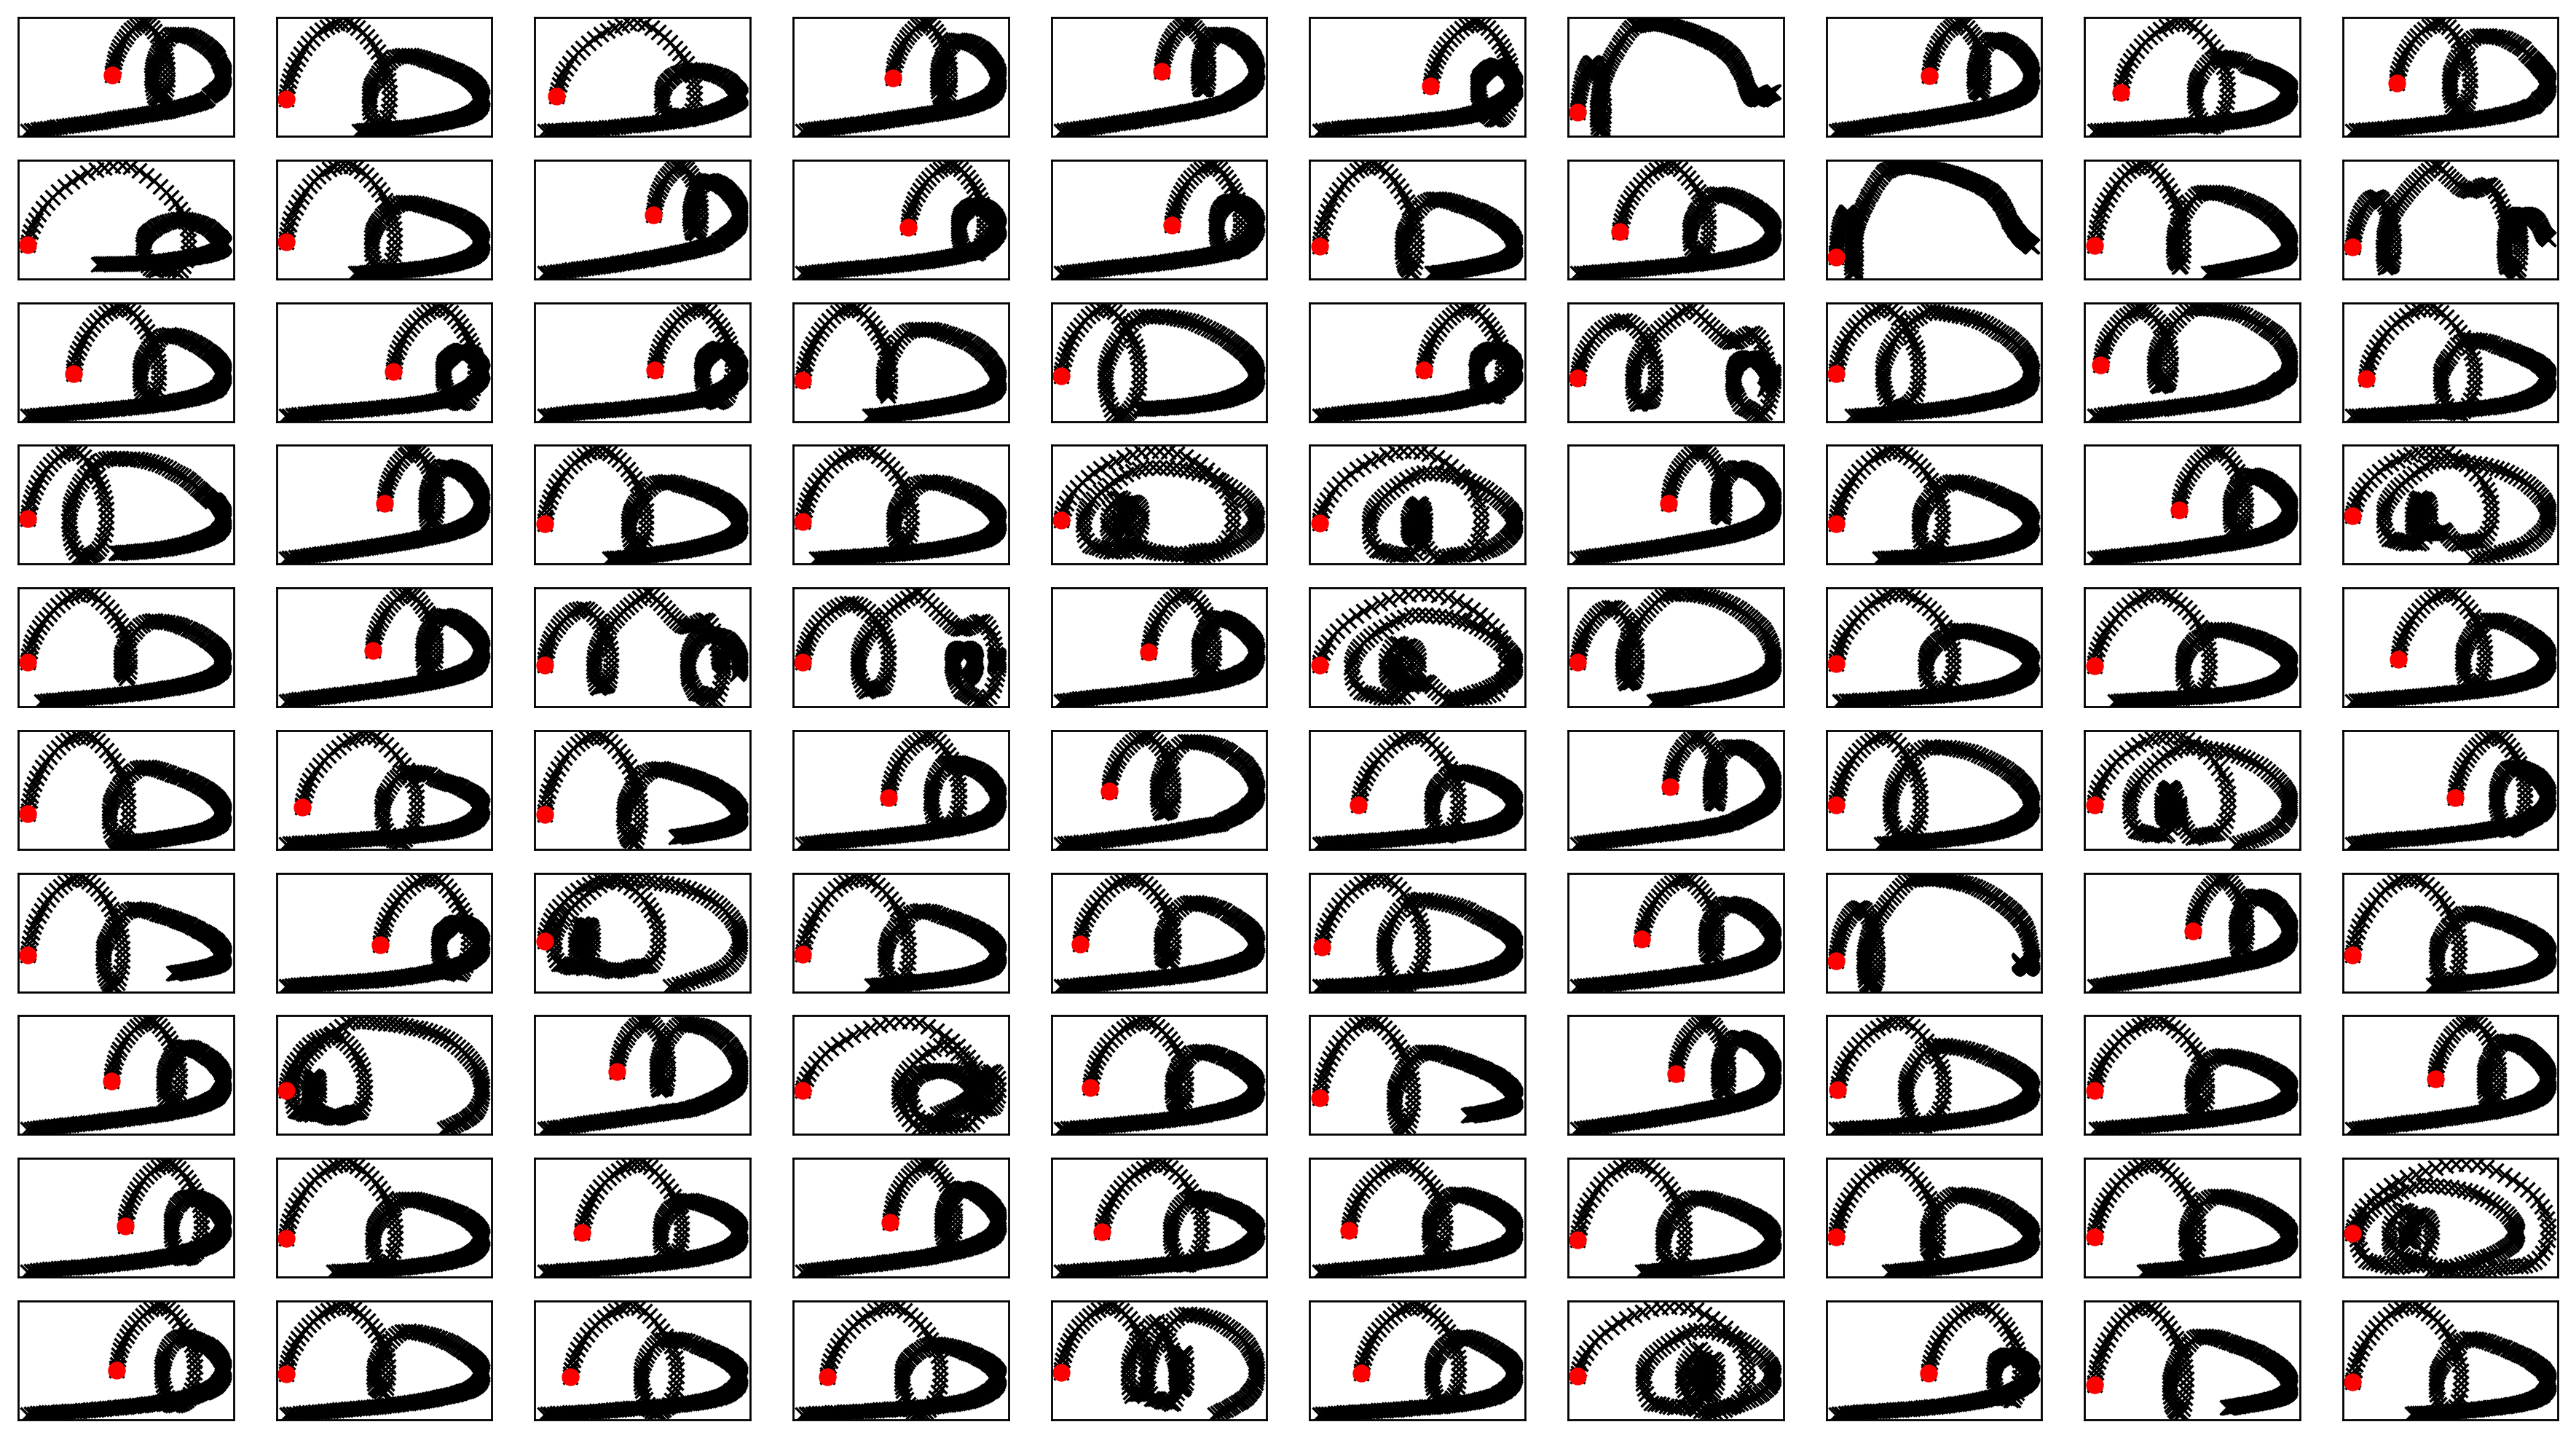

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

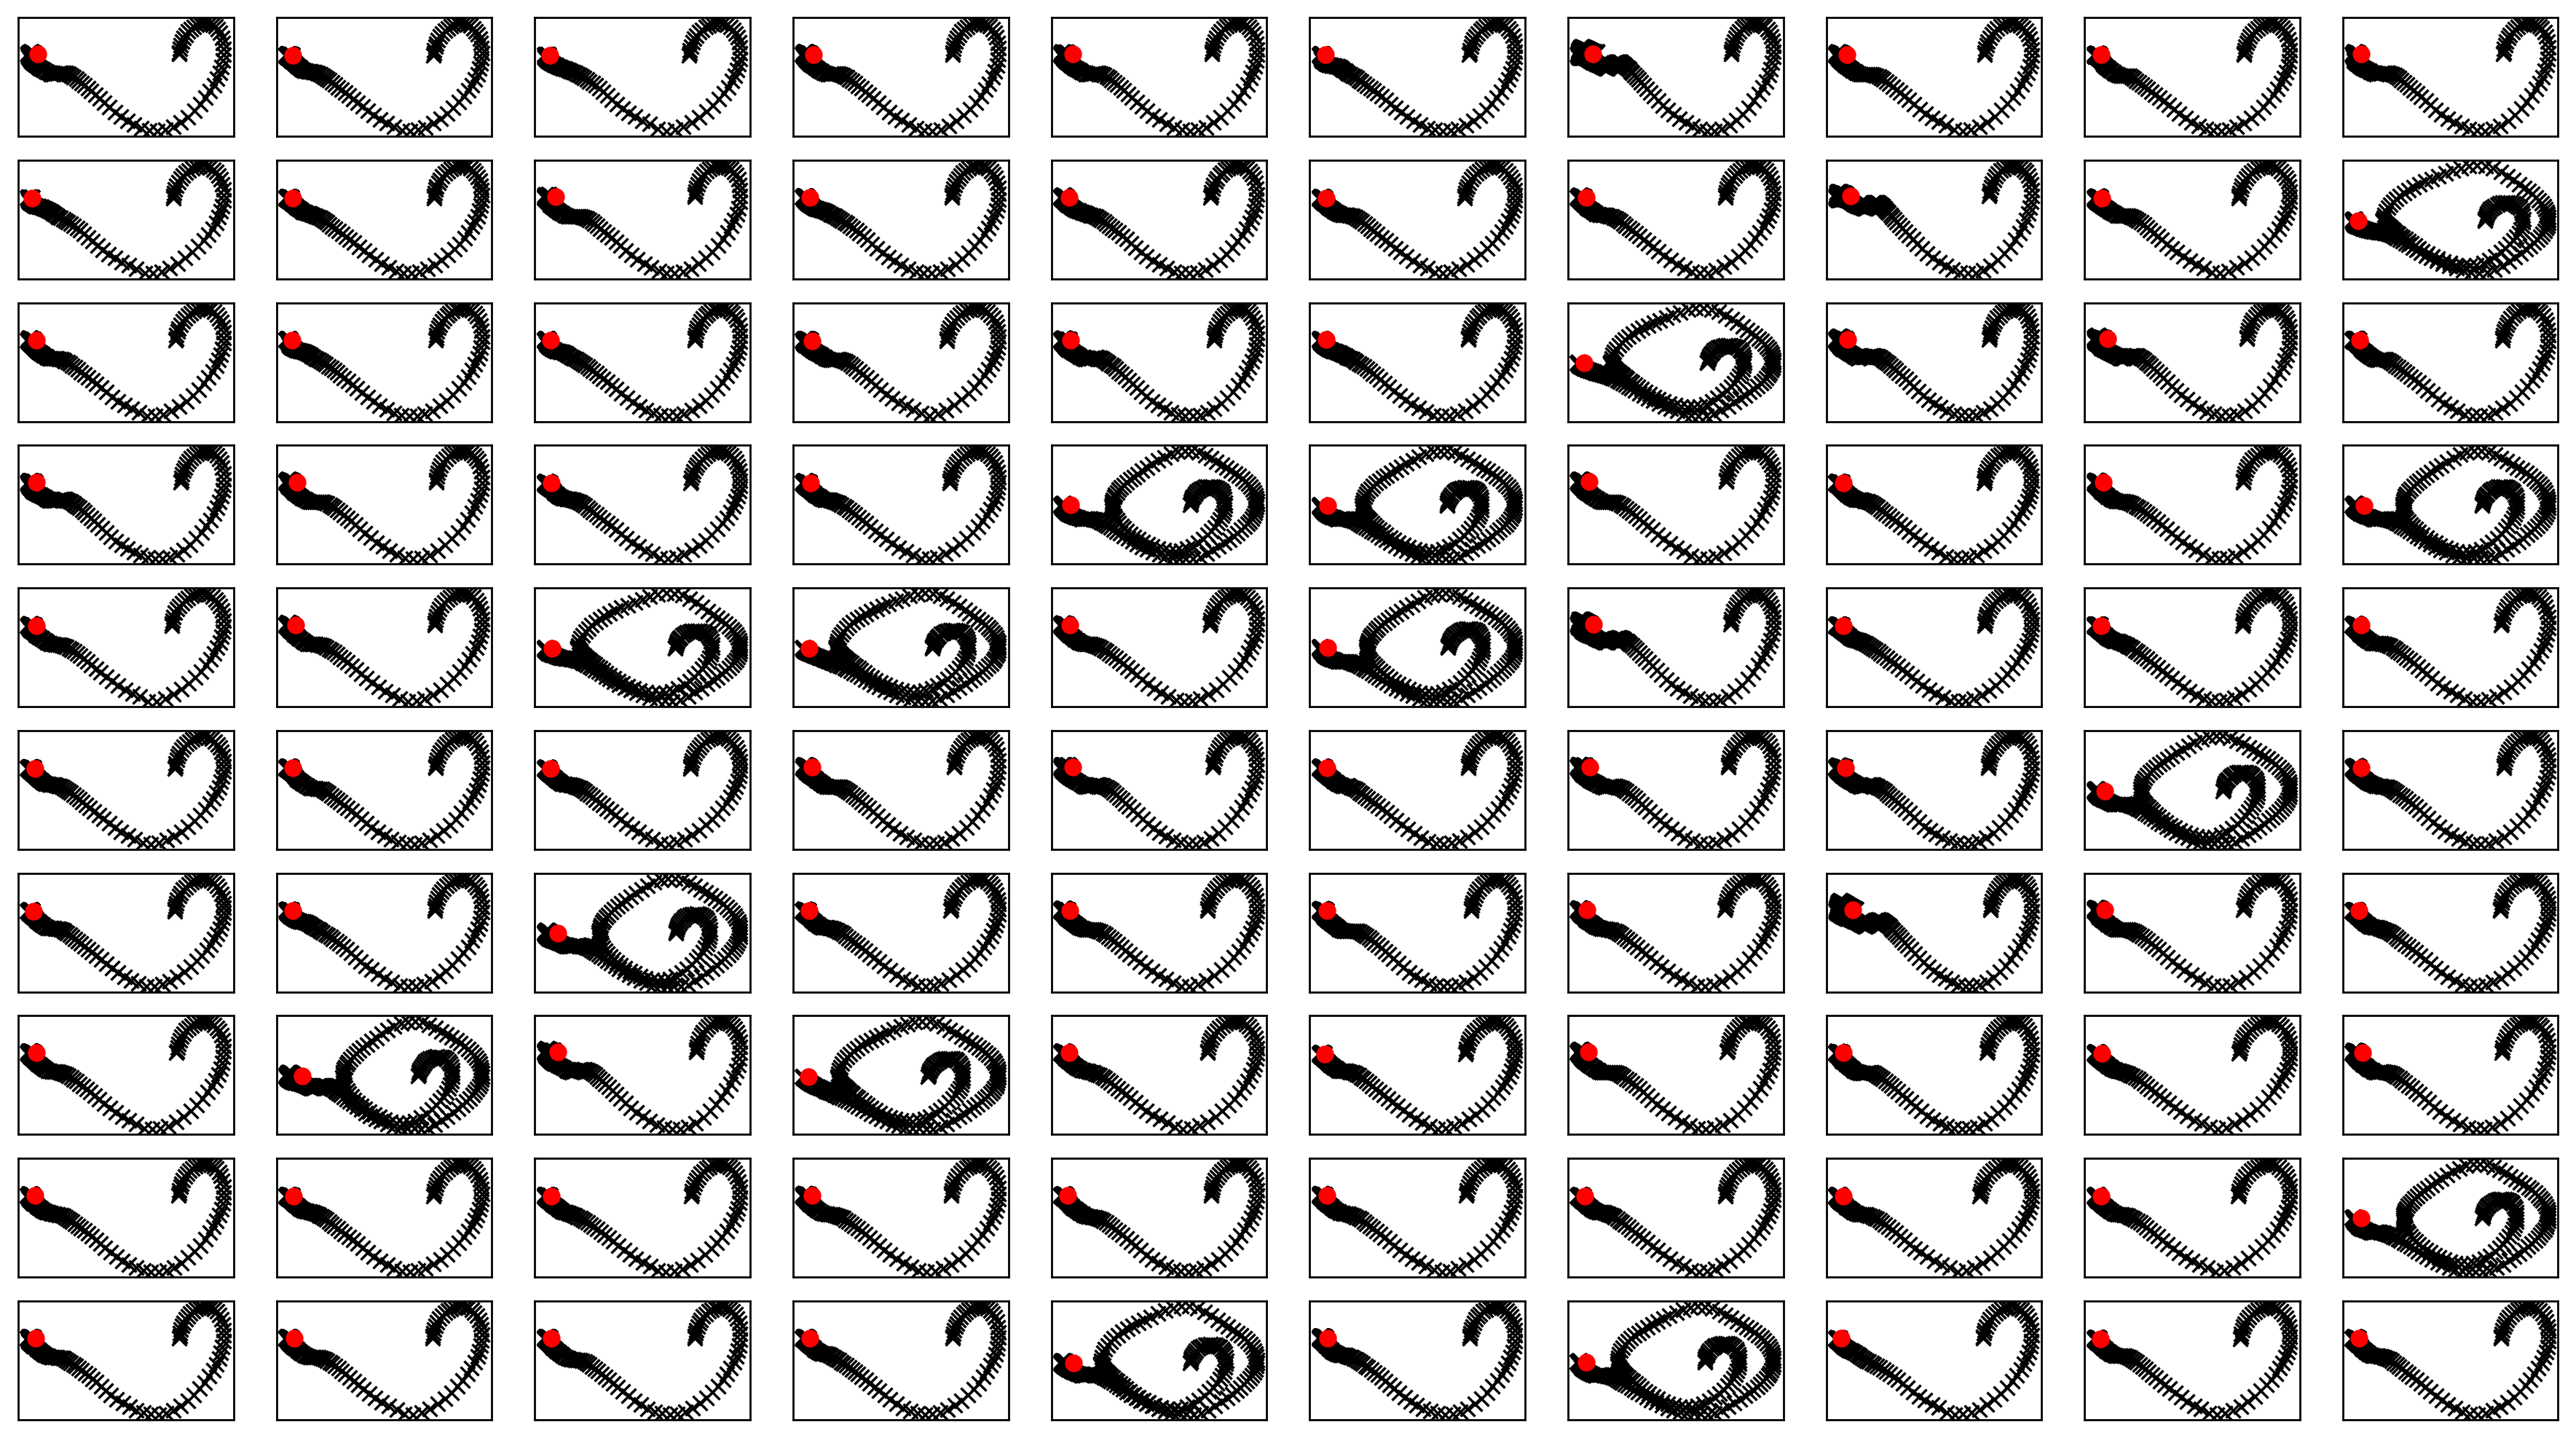

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-22 18:52:01.802772


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36682  validloss 1.43033±0.00000  bestvalidloss 1.43033  last_update 0
train: iter 1  trainloss 1.26432  validloss 1.35468±0.00000  bestvalidloss 1.35468  last_update 0
train: iter 2  trainloss 1.19025  validloss 1.31728±0.00000  bestvalidloss 1.31728  last_update 0
train: iter 3  trainloss 1.14923  validloss 1.30010±0.00000  bestvalidloss 1.30010  last_update 0
train: iter 4  trainloss 1.11591  validloss 1.26906±0.00000  bestvalidloss 1.26906  last_update 0
train: iter 5  trainloss 1.07865  validloss 1.22720±0.00000  bestvalidloss 1.22720  last_update 0
train: iter 6  trainloss 1.04467  validloss 1.19981±0.00000  bestvalidloss 1.19981  last_update 0
train: iter 7  trainloss 1.01482  validloss 1.15410±0.00000  bestvalidloss 1.15410  last_update 0
train: iter 8  trainloss 0.99265  validloss 1.12252±0.00000  bestvalidloss 1.12252  last_update 0
train: iter 9  trainloss 0.96220  validloss 1.06522±0.00000  bestvalidloss 1.06522  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.72148  validloss 0.67075±0.00000  bestvalidloss 0.66631  last_update 8
train: iter 84  trainloss 0.72322  validloss 0.68440±0.00000  bestvalidloss 0.66631  last_update 9
train: iter 85  trainloss 0.71780  validloss 0.66715±0.00000  bestvalidloss 0.66631  last_update 10
train: iter 86  trainloss 0.71154  validloss 0.69317±0.00000  bestvalidloss 0.66631  last_update 11
train: iter 87  trainloss 0.71501  validloss 0.64760±0.00000  bestvalidloss 0.64760  last_update 0
train: iter 88  trainloss 0.71235  validloss 0.68240±0.00000  bestvalidloss 0.64760  last_update 1
train: iter 89  trainloss 0.71932  validloss 0.68643±0.00000  bestvalidloss 0.64760  last_update 2
train: iter 90  trainloss 0.71000  validloss 0.66092±0.00000  bestvalidloss 0.64760  last_update 3
train: iter 91  trainloss 0.71701  validloss 0.67206±0.00000  bestvalidloss 0.64760  last_update 4
train: iter 92  trainloss 0.71118  validloss 0.64957±0.00000  bestvalidloss 0.64760  last_update 5
train: i

train: iter 165  trainloss 0.65925  validloss 0.65811±0.00000  bestvalidloss 0.62555  last_update 1
train: iter 166  trainloss 0.66189  validloss 0.63820±0.00000  bestvalidloss 0.62555  last_update 2
train: iter 167  trainloss 0.65512  validloss 0.63282±0.00000  bestvalidloss 0.62555  last_update 3
train: iter 168  trainloss 0.65766  validloss 0.62105±0.00000  bestvalidloss 0.62105  last_update 0
train: iter 169  trainloss 0.66268  validloss 0.63996±0.00000  bestvalidloss 0.62105  last_update 1
train: iter 170  trainloss 0.64874  validloss 0.63134±0.00000  bestvalidloss 0.62105  last_update 2
train: iter 171  trainloss 0.65516  validloss 0.62714±0.00000  bestvalidloss 0.62105  last_update 3
train: iter 172  trainloss 0.65660  validloss 0.63071±0.00000  bestvalidloss 0.62105  last_update 4
train: iter 173  trainloss 0.66277  validloss 0.64814±0.00000  bestvalidloss 0.62105  last_update 5
train: iter 174  trainloss 0.67591  validloss 0.68002±0.00000  bestvalidloss 0.62105  last_update 6


train: iter 247  trainloss 0.62920  validloss 0.63981±0.00000  bestvalidloss 0.59503  last_update 10
train: iter 248  trainloss 0.62448  validloss 0.63606±0.00000  bestvalidloss 0.59503  last_update 11
train: iter 249  trainloss 0.62528  validloss 0.60024±0.00000  bestvalidloss 0.59503  last_update 12
train: iter 250  trainloss 0.62337  validloss 0.59899±0.00000  bestvalidloss 0.59503  last_update 13
train: iter 251  trainloss 0.61996  validloss 0.60632±0.00000  bestvalidloss 0.59503  last_update 14
train: iter 252  trainloss 0.62770  validloss 0.63338±0.00000  bestvalidloss 0.59503  last_update 15
train: iter 253  trainloss 0.62657  validloss 0.60774±0.00000  bestvalidloss 0.59503  last_update 16
train: iter 254  trainloss 0.62596  validloss 0.62116±0.00000  bestvalidloss 0.59503  last_update 17
train: iter 255  trainloss 0.61912  validloss 0.59789±0.00000  bestvalidloss 0.59503  last_update 18
train: iter 256  trainloss 0.62169  validloss 0.61016±0.00000  bestvalidloss 0.59503  last_

train: iter 329  trainloss 0.60464  validloss 0.61555±0.00000  bestvalidloss 0.57503  last_update 6
train: iter 330  trainloss 0.59940  validloss 0.58916±0.00000  bestvalidloss 0.57503  last_update 7
train: iter 331  trainloss 0.59879  validloss 0.60176±0.00000  bestvalidloss 0.57503  last_update 8
train: iter 332  trainloss 0.59510  validloss 0.59733±0.00000  bestvalidloss 0.57503  last_update 9
train: iter 333  trainloss 0.60004  validloss 0.57765±0.00000  bestvalidloss 0.57503  last_update 10
train: iter 334  trainloss 0.59130  validloss 0.58082±0.00000  bestvalidloss 0.57503  last_update 11
train: iter 335  trainloss 0.60179  validloss 0.58600±0.00000  bestvalidloss 0.57503  last_update 12
train: iter 336  trainloss 0.59676  validloss 0.57491±0.00000  bestvalidloss 0.57491  last_update 0
train: iter 337  trainloss 0.59548  validloss 0.58704±0.00000  bestvalidloss 0.57491  last_update 1
train: iter 338  trainloss 0.59236  validloss 0.58813±0.00000  bestvalidloss 0.57491  last_update

train: iter 412  trainloss 0.57552  validloss 0.58804±0.00000  bestvalidloss 0.56517  last_update 5
train: iter 413  trainloss 0.58004  validloss 0.56870±0.00000  bestvalidloss 0.56517  last_update 6
train: iter 414  trainloss 0.57391  validloss 0.58362±0.00000  bestvalidloss 0.56517  last_update 7
train: iter 415  trainloss 0.57383  validloss 0.58961±0.00000  bestvalidloss 0.56517  last_update 8
train: iter 416  trainloss 0.58555  validloss 0.58087±0.00000  bestvalidloss 0.56517  last_update 9
train: iter 417  trainloss 0.58514  validloss 0.56978±0.00000  bestvalidloss 0.56517  last_update 10
train: iter 418  trainloss 0.59047  validloss 0.61591±0.00000  bestvalidloss 0.56517  last_update 11
train: iter 419  trainloss 0.58024  validloss 0.58297±0.00000  bestvalidloss 0.56517  last_update 12
train: iter 420  trainloss 0.57221  validloss 0.57810±0.00000  bestvalidloss 0.56517  last_update 13
train: iter 421  trainloss 0.57912  validloss 0.57320±0.00000  bestvalidloss 0.56517  last_updat

train: iter 494  trainloss 0.55989  validloss 0.55670±0.00000  bestvalidloss 0.54972  last_update 1
train: iter 495  trainloss 0.56569  validloss 0.56347±0.00000  bestvalidloss 0.54972  last_update 2
train: iter 496  trainloss 0.56344  validloss 0.56291±0.00000  bestvalidloss 0.54972  last_update 3
train: iter 497  trainloss 0.56162  validloss 0.58780±0.00000  bestvalidloss 0.54972  last_update 4
train: iter 498  trainloss 0.56290  validloss 0.55666±0.00000  bestvalidloss 0.54972  last_update 5
train: iter 499  trainloss 0.56040  validloss 0.59059±0.00000  bestvalidloss 0.54972  last_update 6
train: iter 500  trainloss 0.55566  validloss 0.56778±0.00000  bestvalidloss 0.54972  last_update 7
train: iter 501  trainloss 0.55849  validloss 0.56973±0.00000  bestvalidloss 0.54972  last_update 8
train: iter 502  trainloss 0.56445  validloss 0.58947±0.00000  bestvalidloss 0.54972  last_update 9
train: iter 503  trainloss 0.55806  validloss 0.57736±0.00000  bestvalidloss 0.54972  last_update 10

train: iter 576  trainloss 0.55232  validloss 0.56353±0.00000  bestvalidloss 0.54224  last_update 39
train: iter 577  trainloss 0.54298  validloss 0.54714±0.00000  bestvalidloss 0.54224  last_update 40
train: iter 578  trainloss 0.54829  validloss 0.56317±0.00000  bestvalidloss 0.54224  last_update 41
train: iter 579  trainloss 0.54897  validloss 0.55088±0.00000  bestvalidloss 0.54224  last_update 42
train: iter 580  trainloss 0.54071  validloss 0.56397±0.00000  bestvalidloss 0.54224  last_update 43
train: iter 581  trainloss 0.54979  validloss 0.56245±0.00000  bestvalidloss 0.54224  last_update 44
train: iter 582  trainloss 0.54247  validloss 0.56599±0.00000  bestvalidloss 0.54224  last_update 45
train: iter 583  trainloss 0.54355  validloss 0.54303±0.00000  bestvalidloss 0.54224  last_update 46
train: iter 584  trainloss 0.54855  validloss 0.56440±0.00000  bestvalidloss 0.54224  last_update 47
train: iter 585  trainloss 0.54603  validloss 0.55588±0.00000  bestvalidloss 0.54224  last_

train: iter 658  trainloss 0.53988  validloss 0.54037±0.00000  bestvalidloss 0.53486  last_update 12
train: iter 659  trainloss 0.53036  validloss 0.56426±0.00000  bestvalidloss 0.53486  last_update 13
train: iter 660  trainloss 0.53365  validloss 0.55659±0.00000  bestvalidloss 0.53486  last_update 14
train: iter 661  trainloss 0.53278  validloss 0.53316±0.00000  bestvalidloss 0.53316  last_update 0
train: iter 662  trainloss 0.52707  validloss 0.53985±0.00000  bestvalidloss 0.53316  last_update 1
train: iter 663  trainloss 0.53182  validloss 0.54077±0.00000  bestvalidloss 0.53316  last_update 2
train: iter 664  trainloss 0.53375  validloss 0.54533±0.00000  bestvalidloss 0.53316  last_update 3
train: iter 665  trainloss 0.53548  validloss 0.56794±0.00000  bestvalidloss 0.53316  last_update 4
train: iter 666  trainloss 0.52815  validloss 0.54239±0.00000  bestvalidloss 0.53316  last_update 5
train: iter 667  trainloss 0.52935  validloss 0.55066±0.00000  bestvalidloss 0.53316  last_update

train: iter 740  trainloss 0.52359  validloss 0.53828±0.00000  bestvalidloss 0.52871  last_update 63
train: iter 741  trainloss 0.52167  validloss 0.55280±0.00000  bestvalidloss 0.52871  last_update 64
train: iter 742  trainloss 0.52371  validloss 0.53899±0.00000  bestvalidloss 0.52871  last_update 65
train: iter 743  trainloss 0.52537  validloss 0.54950±0.00000  bestvalidloss 0.52871  last_update 66
train: iter 744  trainloss 0.52209  validloss 0.53430±0.00000  bestvalidloss 0.52871  last_update 67
train: iter 745  trainloss 0.52031  validloss 0.54820±0.00000  bestvalidloss 0.52871  last_update 68
train: iter 746  trainloss 0.52293  validloss 0.54842±0.00000  bestvalidloss 0.52871  last_update 69
train: iter 747  trainloss 0.52162  validloss 0.53920±0.00000  bestvalidloss 0.52871  last_update 70
train: iter 748  trainloss 0.52057  validloss 0.53410±0.00000  bestvalidloss 0.52871  last_update 71
train: iter 749  trainloss 0.52487  validloss 0.54734±0.00000  bestvalidloss 0.52871  last_

train: iter 822  trainloss 0.50888  validloss 0.53419±0.00000  bestvalidloss 0.52169  last_update 22
train: iter 823  trainloss 0.51539  validloss 0.54044±0.00000  bestvalidloss 0.52169  last_update 23
train: iter 824  trainloss 0.52015  validloss 0.53128±0.00000  bestvalidloss 0.52169  last_update 24
train: iter 825  trainloss 0.50826  validloss 0.52751±0.00000  bestvalidloss 0.52169  last_update 25
train: iter 826  trainloss 0.52376  validloss 0.54464±0.00000  bestvalidloss 0.52169  last_update 26
train: iter 827  trainloss 0.50942  validloss 0.55625±0.00000  bestvalidloss 0.52169  last_update 27
train: iter 828  trainloss 0.51491  validloss 0.52636±0.00000  bestvalidloss 0.52169  last_update 28
train: iter 829  trainloss 0.51707  validloss 0.53243±0.00000  bestvalidloss 0.52169  last_update 29
train: iter 830  trainloss 0.50939  validloss 0.52881±0.00000  bestvalidloss 0.52169  last_update 30
train: iter 831  trainloss 0.51283  validloss 0.53313±0.00000  bestvalidloss 0.52169  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.499082040134072
valid_loss:  -6.631367317080496
weight_alpha 1.0 h_min_tilde -12.308785 ell_tilde -4.925539095523357 kappa_tilde 0.0003680241518702558
train_loss:  -6.638268815994263
valid_loss:  -6.382598155212403
weight_alpha 0.1 h_min_tilde -12.308785 ell_tilde -6.587134683837891 kappa_tilde 0.0004180606845615644


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1306.33230  validloss -1279.14234±0.00000  bestvalidloss -1279.14234  last_update 0
train: iter 1  trainloss -1316.75054  validloss -1265.41359±0.00000  bestvalidloss -1279.14234  last_update 1
train: iter 2  trainloss -1316.07197  validloss -1248.67121±0.00000  bestvalidloss -1279.14234  last_update 2
train: iter 3  trainloss -1313.24829  validloss -1264.11360±0.00000  bestvalidloss -1279.14234  last_update 3
train: iter 4  trainloss -1309.28870  validloss -1246.67586±0.00000  bestvalidloss -1279.14234  last_update 4
train: iter 5  trainloss -1318.24622  validloss -1248.97623±0.00000  bestvalidloss -1279.14234  last_update 5
train: iter 6  trainloss -1316.91821  validloss -1237.81270±0.00000  bestvalidloss -1279.14234  last_update 6
train: iter 7  trainloss -1285.27808  validloss -1139.42540±0.00000  bestvalidloss -1279.14234  last_update 7
train: iter 8  trainloss -1316.23752  validloss -1200.20982±0.00000  bestva

train: iter 74  trainloss -1334.36114  validloss -1246.70324±0.00000  bestvalidloss -1338.63703  last_update 37
train: iter 75  trainloss -1325.83630  validloss -1204.19191±0.00000  bestvalidloss -1338.63703  last_update 38
train: iter 76  trainloss -1319.72499  validloss -1240.55284±0.00000  bestvalidloss -1338.63703  last_update 39
train: iter 77  trainloss -1324.97038  validloss -1225.04368±0.00000  bestvalidloss -1338.63703  last_update 40
train: iter 78  trainloss -1327.65028  validloss -1259.13934±0.00000  bestvalidloss -1338.63703  last_update 41
train: iter 79  trainloss -1334.21713  validloss -1233.22607±0.00000  bestvalidloss -1338.63703  last_update 42
train: iter 80  trainloss -1321.32049  validloss -1228.52147±0.00000  bestvalidloss -1338.63703  last_update 43
train: iter 81  trainloss -1316.70547  validloss -1224.92623±0.00000  bestvalidloss -1338.63703  last_update 44
train: iter 82  trainloss -1299.49517  validloss -1222.07581±0.00000  bestvalidloss -1338.63703  last_up

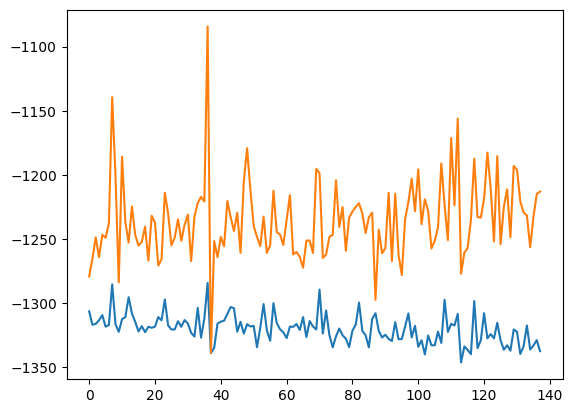

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-22 19:18:21.718136


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.67157  validloss 0.68813±0.00000  bestvalidloss 0.68813  last_update 0
train: iter 1  trainloss 0.62640  validloss 0.57967±0.00000  bestvalidloss 0.57967  last_update 0
train: iter 2  trainloss 0.61762  validloss 0.58776±0.00000  bestvalidloss 0.57967  last_update 1
train: iter 3  trainloss 0.61117  validloss 0.58926±0.00000  bestvalidloss 0.57967  last_update 2
train: iter 4  trainloss 0.61485  validloss 0.56671±0.00000  bestvalidloss 0.56671  last_update 0
train: iter 5  trainloss 0.60848  validloss 0.55739±0.00000  bestvalidloss 0.55739  last_update 0
train: iter 6  trainloss 0.59750  validloss 0.57768±0.00000  bestvalidloss 0.55739  last_update 1
train: iter 7  trainloss 0.61213  validloss 0.55012±0.00000  bestvalidloss 0.55012  last_update 0
train: iter 8  trainloss 0.59975  validloss 0.55324±0.00000  bestvalidloss 0.55012  last_update 1
train: iter 9  trainloss 0.59642  validloss 0.55151±0.00000  bestvalidloss 0.55012  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.55048  validloss 0.54027±0.00000  bestvalidloss 0.52776  last_update 25
train: iter 84  trainloss 0.55923  validloss 0.54935±0.00000  bestvalidloss 0.52776  last_update 26
train: iter 85  trainloss 0.55220  validloss 0.55907±0.00000  bestvalidloss 0.52776  last_update 27
train: iter 86  trainloss 0.54843  validloss 0.54216±0.00000  bestvalidloss 0.52776  last_update 28
train: iter 87  trainloss 0.55243  validloss 0.54601±0.00000  bestvalidloss 0.52776  last_update 29
train: iter 88  trainloss 0.55073  validloss 0.55365±0.00000  bestvalidloss 0.52776  last_update 30
train: iter 89  trainloss 0.54748  validloss 0.54762±0.00000  bestvalidloss 0.52776  last_update 31
train: iter 90  trainloss 0.55527  validloss 0.54721±0.00000  bestvalidloss 0.52776  last_update 32
train: iter 91  trainloss 0.55679  validloss 0.55585±0.00000  bestvalidloss 0.52776  last_update 33
train: iter 92  trainloss 0.55305  validloss 0.53873±0.00000  bestvalidloss 0.52776  last_update 34


train: iter 165  trainloss 0.52986  validloss 0.52521±0.00000  bestvalidloss 0.52128  last_update 21
train: iter 166  trainloss 0.53117  validloss 0.52897±0.00000  bestvalidloss 0.52128  last_update 22
train: iter 167  trainloss 0.53079  validloss 0.53633±0.00000  bestvalidloss 0.52128  last_update 23
train: iter 168  trainloss 0.52658  validloss 0.54915±0.00000  bestvalidloss 0.52128  last_update 24
train: iter 169  trainloss 0.53011  validloss 0.54015±0.00000  bestvalidloss 0.52128  last_update 25
train: iter 170  trainloss 0.52540  validloss 0.52718±0.00000  bestvalidloss 0.52128  last_update 26
train: iter 171  trainloss 0.53848  validloss 0.52529±0.00000  bestvalidloss 0.52128  last_update 27
train: iter 172  trainloss 0.52595  validloss 0.53873±0.00000  bestvalidloss 0.52128  last_update 28
train: iter 173  trainloss 0.53869  validloss 0.54214±0.00000  bestvalidloss 0.52128  last_update 29
train: iter 174  trainloss 0.52740  validloss 0.52579±0.00000  bestvalidloss 0.52128  last_

train: iter 247  trainloss 0.51273  validloss 0.54490±0.00000  bestvalidloss 0.51340  last_update 5
train: iter 248  trainloss 0.51215  validloss 0.52407±0.00000  bestvalidloss 0.51340  last_update 6
train: iter 249  trainloss 0.51034  validloss 0.53021±0.00000  bestvalidloss 0.51340  last_update 7
train: iter 250  trainloss 0.51020  validloss 0.52875±0.00000  bestvalidloss 0.51340  last_update 8
train: iter 251  trainloss 0.50626  validloss 0.51254±0.00000  bestvalidloss 0.51254  last_update 0
train: iter 252  trainloss 0.50585  validloss 0.53178±0.00000  bestvalidloss 0.51254  last_update 1
train: iter 253  trainloss 0.50529  validloss 0.52167±0.00000  bestvalidloss 0.51254  last_update 2
train: iter 254  trainloss 0.50206  validloss 0.51334±0.00000  bestvalidloss 0.51254  last_update 3
train: iter 255  trainloss 0.50718  validloss 0.53435±0.00000  bestvalidloss 0.51254  last_update 4
train: iter 256  trainloss 0.51850  validloss 0.53538±0.00000  bestvalidloss 0.51254  last_update 5


train: iter 330  trainloss 0.49206  validloss 0.52090±0.00000  bestvalidloss 0.50209  last_update 35
train: iter 331  trainloss 0.49942  validloss 0.51966±0.00000  bestvalidloss 0.50209  last_update 36
train: iter 332  trainloss 0.48948  validloss 0.52077±0.00000  bestvalidloss 0.50209  last_update 37
train: iter 333  trainloss 0.48768  validloss 0.52030±0.00000  bestvalidloss 0.50209  last_update 38
train: iter 334  trainloss 0.49045  validloss 0.51299±0.00000  bestvalidloss 0.50209  last_update 39
train: iter 335  trainloss 0.49038  validloss 0.50151±0.00000  bestvalidloss 0.50151  last_update 0
train: iter 336  trainloss 0.49670  validloss 0.53484±0.00000  bestvalidloss 0.50151  last_update 1
train: iter 337  trainloss 0.49656  validloss 0.53227±0.00000  bestvalidloss 0.50151  last_update 2
train: iter 338  trainloss 0.48659  validloss 0.53776±0.00000  bestvalidloss 0.50151  last_update 3
train: iter 339  trainloss 0.49594  validloss 0.50353±0.00000  bestvalidloss 0.50151  last_upda

train: iter 412  trainloss 0.48121  validloss 0.50626±0.00000  bestvalidloss 0.49565  last_update 13
train: iter 413  trainloss 0.47863  validloss 0.50666±0.00000  bestvalidloss 0.49565  last_update 14
train: iter 414  trainloss 0.47380  validloss 0.49711±0.00000  bestvalidloss 0.49565  last_update 15
train: iter 415  trainloss 0.47792  validloss 0.53077±0.00000  bestvalidloss 0.49565  last_update 16
train: iter 416  trainloss 0.47722  validloss 0.50257±0.00000  bestvalidloss 0.49565  last_update 17
train: iter 417  trainloss 0.47697  validloss 0.50674±0.00000  bestvalidloss 0.49565  last_update 18
train: iter 418  trainloss 0.47299  validloss 0.49923±0.00000  bestvalidloss 0.49565  last_update 19
train: iter 419  trainloss 0.47761  validloss 0.50487±0.00000  bestvalidloss 0.49565  last_update 20
train: iter 420  trainloss 0.47364  validloss 0.51490±0.00000  bestvalidloss 0.49565  last_update 21
train: iter 421  trainloss 0.47395  validloss 0.51761±0.00000  bestvalidloss 0.49565  last_

train: iter 495  trainloss 0.46328  validloss 0.51077±0.00000  bestvalidloss 0.49545  last_update 58
train: iter 496  trainloss 0.46254  validloss 0.53557±0.00000  bestvalidloss 0.49545  last_update 59
train: iter 497  trainloss 0.46444  validloss 0.54503±0.00000  bestvalidloss 0.49545  last_update 60
train: iter 498  trainloss 0.46797  validloss 0.49698±0.00000  bestvalidloss 0.49545  last_update 61
train: iter 499  trainloss 0.45954  validloss 0.49902±0.00000  bestvalidloss 0.49545  last_update 62
train: iter 500  trainloss 0.46852  validloss 0.50529±0.00000  bestvalidloss 0.49545  last_update 63
train: iter 501  trainloss 0.46534  validloss 0.52682±0.00000  bestvalidloss 0.49545  last_update 64
train: iter 502  trainloss 0.46074  validloss 0.50948±0.00000  bestvalidloss 0.49545  last_update 65
train: iter 503  trainloss 0.46011  validloss 0.51123±0.00000  bestvalidloss 0.49545  last_update 66
train: iter 504  trainloss 0.46441  validloss 0.51035±0.00000  bestvalidloss 0.49545  last_

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.6722392180264
valid_loss:  -7.054025514936447
weight_alpha 1.0 h_min_tilde -12.317751 ell_tilde -5.94859647740841 kappa_tilde 0.00039624072502160017
train_loss:  -6.592209423065187
valid_loss:  -6.259762220764161
weight_alpha 0.1 h_min_tilde -12.317751 ell_tilde -6.525719982604982 kappa_tilde 0.0004155129494755158


In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1315.28787  validloss -1250.86297±0.00000  bestvalidloss -1250.86297  last_update 0
train: iter 1  trainloss -1319.84822  validloss -1290.24180±0.00000  bestvalidloss -1290.24180  last_update 0
train: iter 2  trainloss -1316.04881  validloss -1279.11515±0.00000  bestvalidloss -1290.24180  last_update 1
train: iter 3  trainloss -1324.33780  validloss -1261.77709±0.00000  bestvalidloss -1290.24180  last_update 2
train: iter 4  trainloss -1337.07920  validloss -1276.04654±0.00000  bestvalidloss -1290.24180  last_update 3
train: iter 5  trainloss -1323.80886  validloss -1274.16405±0.00000  bestvalidloss -1290.24180  last_update 4
train: iter 6  trainloss -1303.03354  validloss -1224.99984±0.00000  bestvalidloss -1290.24180  last_update 5
train: iter 7  trainloss -1321.03743  validloss -1269.33905±0.00000  bestvalidloss -1290.24180  last_update 6
train: iter 8  trainloss -1329.04088  validloss -1286.98083±0.00000  bestva

train: iter 75  trainloss -1335.10094  validloss -1117.11143±0.00000  bestvalidloss -1310.31153  last_update 59
train: iter 76  trainloss -1339.38261  validloss -1266.69393±0.00000  bestvalidloss -1310.31153  last_update 60
train: iter 77  trainloss -1320.59547  validloss -1256.45149±0.00000  bestvalidloss -1310.31153  last_update 61
train: iter 78  trainloss -1321.50581  validloss -1310.87155±0.00000  bestvalidloss -1310.87155  last_update 0
train: iter 79  trainloss -1316.59211  validloss -1247.13051±0.00000  bestvalidloss -1310.87155  last_update 1
train: iter 80  trainloss -1332.78391  validloss -1254.92676±0.00000  bestvalidloss -1310.87155  last_update 2
train: iter 81  trainloss -1331.00621  validloss -1169.84796±0.00000  bestvalidloss -1310.87155  last_update 3
train: iter 82  trainloss -1335.71960  validloss -1281.14741±0.00000  bestvalidloss -1310.87155  last_update 4
train: iter 83  trainloss -1294.15894  validloss -1289.07037±0.00000  bestvalidloss -1310.87155  last_update 

train: iter 148  trainloss -1335.01555  validloss -1232.84782±0.00000  bestvalidloss -1310.87155  last_update 70
train: iter 149  trainloss -1330.63493  validloss -1266.32261±0.00000  bestvalidloss -1310.87155  last_update 71
train: iter 150  trainloss -1332.61738  validloss -1281.06201±0.00000  bestvalidloss -1310.87155  last_update 72
train: iter 151  trainloss -1333.08813  validloss -1229.22307±0.00000  bestvalidloss -1310.87155  last_update 73
train: iter 152  trainloss -1321.96819  validloss -1232.68959±0.00000  bestvalidloss -1310.87155  last_update 74
train: iter 153  trainloss -1324.32521  validloss -1251.83481±0.00000  bestvalidloss -1310.87155  last_update 75
train: iter 154  trainloss -1340.77620  validloss -1265.39630±0.00000  bestvalidloss -1310.87155  last_update 76
train: iter 155  trainloss -1335.82505  validloss -1256.16886±0.00000  bestvalidloss -1310.87155  last_update 77
train: iter 156  trainloss -1338.15062  validloss -1261.23484±0.00000  bestvalidloss -1310.87155

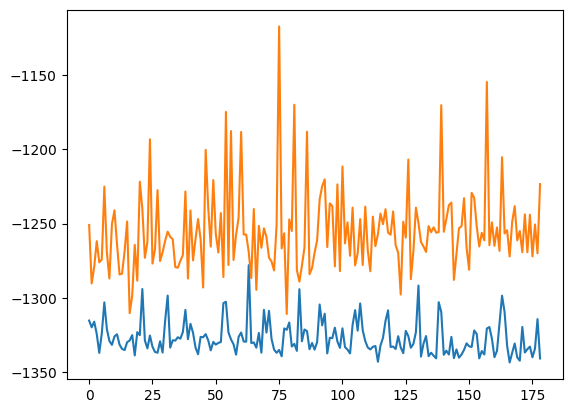

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-22 19:43:47.985323


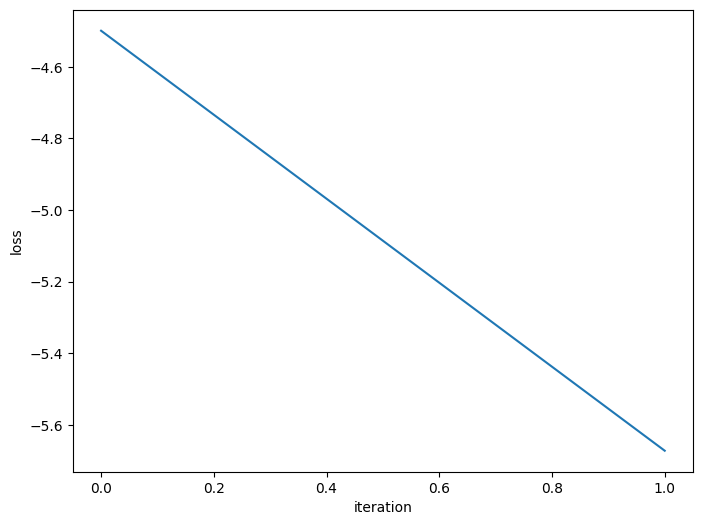

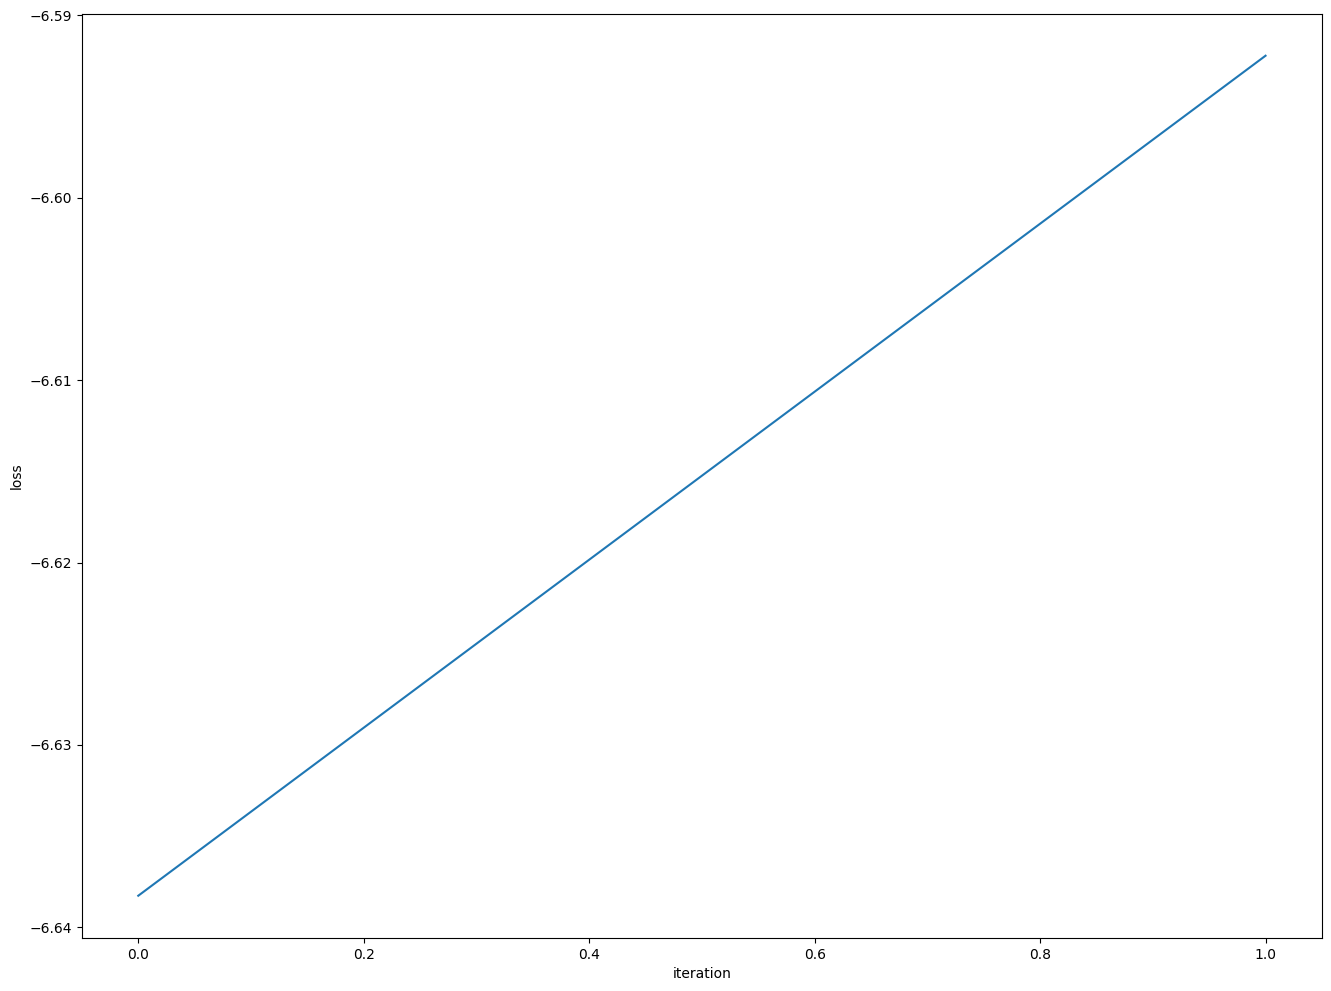

In [25]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(16,12))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [26]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [27]:
policy_evaluation_iter=2

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39
predict diverge [ -3.5503779    2.72865722  -8.06373348 -22.72972197] [ 0.06460137  1.28102116 -0.39796189 -5.98961977] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 155

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96
predict diverge [ -4.54047992   1.97399363  -6.65776544 -25.77171642] [ 0.08246836  2.06239121 -0.38114892 -7.8255305 ] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 137

 97

 98

 99
 


In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.73755  validloss 0.69114±0.00000  bestvalidloss 0.69114  last_update 0
train: iter 1  trainloss 0.68265  validloss 0.57101±0.00000  bestvalidloss 0.57101  last_update 0
train: iter 2  trainloss 0.65859  validloss 0.58300±0.00000  bestvalidloss 0.57101  last_update 1
train: iter 3  trainloss 0.63848  validloss 0.56003±0.00000  bestvalidloss 0.56003  last_update 0
train: iter 4  trainloss 0.62303  validloss 0.56584±0.00000  bestvalidloss 0.56003  last_update 1
train: iter 5  trainloss 0.61476  validloss 0.57005±0.00000  bestvalidloss 0.56003  last_update 2
train: iter 6  trainloss 0.61035  validloss 0.56325±0.00000  bestvalidloss 0.56003  last_update 3
train: iter 7  trainloss 0.59987  validloss 0.57906±0.00000  bestvalidloss 0.56003  last_update 4
train: iter 8  trainloss 0.60230  validloss 0.57341±0.00000  bestvalidloss 0.56003  last_update 5
train: iter 9  trainloss 0.59702  validloss 0.53999±0.00000  bestvalidloss 0.53999  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.52657  validloss 0.53845±0.00000  bestvalidloss 0.52715  last_update 52
train: iter 84  trainloss 0.53743  validloss 0.54811±0.00000  bestvalidloss 0.52715  last_update 53
train: iter 85  trainloss 0.52857  validloss 0.54034±0.00000  bestvalidloss 0.52715  last_update 54
train: iter 86  trainloss 0.53277  validloss 0.53867±0.00000  bestvalidloss 0.52715  last_update 55
train: iter 87  trainloss 0.52672  validloss 0.55899±0.00000  bestvalidloss 0.52715  last_update 56
train: iter 88  trainloss 0.53253  validloss 0.56846±0.00000  bestvalidloss 0.52715  last_update 57
train: iter 89  trainloss 0.52671  validloss 0.54337±0.00000  bestvalidloss 0.52715  last_update 58
train: iter 90  trainloss 0.52843  validloss 0.56056±0.00000  bestvalidloss 0.52715  last_update 59
train: iter 91  trainloss 0.52564  validloss 0.53422±0.00000  bestvalidloss 0.52715  last_update 60
train: iter 92  trainloss 0.52263  validloss 0.54321±0.00000  bestvalidloss 0.52715  last_update 61


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.904878479924799
valid_loss:  -8.308494671440124
weight_alpha 1.0 h_min_tilde -12.322908 ell_tilde -7.185601718227863 kappa_tilde 0.00044119669821570783
train_loss:  -7.1411508333206175
valid_loss:  -6.8517930095672614
weight_alpha 0.1 h_min_tilde -12.322908 ell_tilde -7.083279268569946 kappa_tilde 0.0004368674885058052


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1405.80105  validloss -1371.80077±0.00000  bestvalidloss -1371.80077  last_update 0
train: iter 1  trainloss -1410.37134  validloss -1361.30870±0.00000  bestvalidloss -1371.80077  last_update 1
train: iter 2  trainloss -1414.31940  validloss -1418.51700±0.00000  bestvalidloss -1418.51700  last_update 0
train: iter 3  trainloss -1404.14615  validloss -1380.21847±0.00000  bestvalidloss -1418.51700  last_update 1
train: iter 4  trainloss -1376.19837  validloss -1307.68518±0.00000  bestvalidloss -1418.51700  last_update 2
train: iter 5  trainloss -1405.59727  validloss -1386.72346±0.00000  bestvalidloss -1418.51700  last_update 3
train: iter 6  trainloss -1403.62058  validloss -1379.46770±0.00000  bestvalidloss -1418.51700  last_update 4
train: iter 7  trainloss -1413.59141  validloss -1405.77964±0.00000  bestvalidloss -1418.51700  last_update 5
train: iter 8  trainloss -1419.95960  validloss -1342.72183±0.00000  bestva

train: iter 73  trainloss -1420.50803  validloss -1397.86251±0.00000  bestvalidloss -1418.51700  last_update 71
train: iter 74  trainloss -1339.14566  validloss -1350.80551±0.00000  bestvalidloss -1418.51700  last_update 72
train: iter 75  trainloss -1418.28265  validloss -1440.45488±0.00000  bestvalidloss -1440.45488  last_update 0
train: iter 76  trainloss -1409.32957  validloss -1398.13672±0.00000  bestvalidloss -1440.45488  last_update 1
train: iter 77  trainloss -1422.12937  validloss -1405.85988±0.00000  bestvalidloss -1440.45488  last_update 2
train: iter 78  trainloss -1409.80326  validloss -1391.23259±0.00000  bestvalidloss -1440.45488  last_update 3
train: iter 79  trainloss -1408.74175  validloss -1373.60693±0.00000  bestvalidloss -1440.45488  last_update 4
train: iter 80  trainloss -1403.74558  validloss -1391.07693±0.00000  bestvalidloss -1440.45488  last_update 5
train: iter 81  trainloss -1410.95993  validloss -1389.32913±0.00000  bestvalidloss -1440.45488  last_update 6

train: iter 146  trainloss -1418.23079  validloss -1384.95878±0.00000  bestvalidloss -1440.45488  last_update 71
train: iter 147  trainloss -1410.10997  validloss -1368.46558±0.00000  bestvalidloss -1440.45488  last_update 72
train: iter 148  trainloss -1407.95468  validloss -1386.12565±0.00000  bestvalidloss -1440.45488  last_update 73
train: iter 149  trainloss -1413.24466  validloss -1403.63051±0.00000  bestvalidloss -1440.45488  last_update 74
train: iter 150  trainloss -1416.36046  validloss -1413.36600±0.00000  bestvalidloss -1440.45488  last_update 75
train: iter 151  trainloss -1416.15581  validloss -1402.72941±0.00000  bestvalidloss -1440.45488  last_update 76
train: iter 152  trainloss -1325.80832  validloss -1304.87340±0.00000  bestvalidloss -1440.45488  last_update 77
train: iter 153  trainloss -1393.97953  validloss -1268.19003±0.00000  bestvalidloss -1440.45488  last_update 78
train: iter 154  trainloss -1401.17747  validloss -1336.89654±0.00000  bestvalidloss -1440.45488

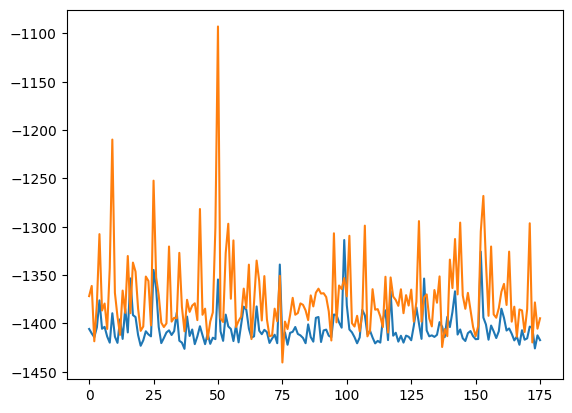

alpha 0.1 default_lr 0.0005


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [33]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [34]:
print(datetime.datetime.now())

2023-07-22 20:05:00.720607


# Iter 4

In [35]:
policy_evaluation_iter=3

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.61939  validloss 0.68000±0.00000  bestvalidloss 0.68000  last_update 0
train: iter 1  trainloss 0.59872  validloss 0.62363±0.00000  bestvalidloss 0.62363  last_update 0
train: iter 2  trainloss 0.60325  validloss 0.63934±0.00000  bestvalidloss 0.62363  last_update 1
train: iter 3  trainloss 0.59217  validloss 0.63950±0.00000  bestvalidloss 0.62363  last_update 2
train: iter 4  trainloss 0.59015  validloss 0.64790±0.00000  bestvalidloss 0.62363  last_update 3
train: iter 5  trainloss 0.58684  validloss 0.63436±0.00000  bestvalidloss 0.62363  last_update 4
train: iter 6  trainloss 0.58018  validloss 0.62595±0.00000  bestvalidloss 0.62363  last_update 5
train: iter 7  trainloss 0.57279  validloss 0.62766±0.00000  bestvalidloss 0.62363  last_update 6
train: iter 8  trainloss 0.57314  validloss 0.60361±0.00000  bestvalidloss 0.60361  last_update 0
train: iter 9  trainloss 0.56898  validloss 0.62172±0.00000  bestvalidloss 0.60361  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.51446  validloss 0.61385±0.00000  bestvalidloss 0.60361  last_update 75
train: iter 84  trainloss 0.51870  validloss 0.60536±0.00000  bestvalidloss 0.60361  last_update 76
train: iter 85  trainloss 0.52285  validloss 0.66044±0.00000  bestvalidloss 0.60361  last_update 77
train: iter 86  trainloss 0.51426  validloss 0.62621±0.00000  bestvalidloss 0.60361  last_update 78
train: iter 87  trainloss 0.51850  validloss 0.62582±0.00000  bestvalidloss 0.60361  last_update 79
train: iter 88  trainloss 0.51806  validloss 0.60532±0.00000  bestvalidloss 0.60361  last_update 80
train: iter 89  trainloss 0.51480  validloss 0.61518±0.00000  bestvalidloss 0.60361  last_update 81
train: iter 90  trainloss 0.51827  validloss 0.63553±0.00000  bestvalidloss 0.60361  last_update 82
train: iter 91  trainloss 0.51520  validloss 0.65009±0.00000  bestvalidloss 0.60361  last_update 83
train: iter 92  trainloss 0.51956  validloss 0.64294±0.00000  bestvalidloss 0.60361  last_update 84


In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.983629868268966
valid_loss:  -10.1498027425766
weight_alpha 1.0 h_min_tilde -12.320155 ell_tilde -7.616864443130493 kappa_tilde 0.00046110421141788466
train_loss:  -7.294114513778686
valid_loss:  -7.2828224098205565
weight_alpha 0.1 h_min_tilde -12.320155 ell_tilde -7.29185609298706 kappa_tilde 0.000445953370436396


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1432.14051  validloss -1455.42476±0.00000  bestvalidloss -1455.42476  last_update 0
train: iter 1  trainloss -1472.54152  validloss -1460.62993±0.00000  bestvalidloss -1460.62993  last_update 0
train: iter 2  trainloss -1465.80070  validloss -1469.08668±0.00000  bestvalidloss -1469.08668  last_update 0
train: iter 3  trainloss -1430.99247  validloss -1405.12583±0.00000  bestvalidloss -1469.08668  last_update 1
train: iter 4  trainloss -1435.35005  validloss -1432.89693±0.00000  bestvalidloss -1469.08668  last_update 2
train: iter 5  trainloss -1459.43970  validloss -1441.89468±0.00000  bestvalidloss -1469.08668  last_update 3
train: iter 6  trainloss -1466.53583  validloss -1409.23890±0.00000  bestvalidloss -1469.08668  last_update 4
train: iter 7  trainloss -1467.96419  validloss -1482.38927±0.00000  bestvalidloss -1482.38927  last_update 0
train: iter 8  trainloss -1470.11169  validloss -1431.04373±0.00000  bestva

train: iter 73  trainloss -1466.60068  validloss -1426.34727±0.00000  bestvalidloss -1482.38927  last_update 66
train: iter 74  trainloss -1462.71955  validloss -1427.67343±0.00000  bestvalidloss -1482.38927  last_update 67
train: iter 75  trainloss -1401.55878  validloss -1449.77105±0.00000  bestvalidloss -1482.38927  last_update 68
train: iter 76  trainloss -1423.61532  validloss -1407.62527±0.00000  bestvalidloss -1482.38927  last_update 69
train: iter 77  trainloss -1438.39324  validloss -1441.61628±0.00000  bestvalidloss -1482.38927  last_update 70
train: iter 78  trainloss -1462.86806  validloss -1436.10793±0.00000  bestvalidloss -1482.38927  last_update 71
train: iter 79  trainloss -1464.24433  validloss -1430.99000±0.00000  bestvalidloss -1482.38927  last_update 72
train: iter 80  trainloss -1462.61733  validloss -1398.72028±0.00000  bestvalidloss -1482.38927  last_update 73
train: iter 81  trainloss -1464.06238  validloss -1477.49332±0.00000  bestvalidloss -1482.38927  last_up

train: iter 146  trainloss -1470.07719  validloss -1472.60265±0.00000  bestvalidloss -1482.98540  last_update 46
train: iter 147  trainloss -1462.79923  validloss -1447.03468±0.00000  bestvalidloss -1482.98540  last_update 47
train: iter 148  trainloss -1471.70077  validloss -1454.94866±0.00000  bestvalidloss -1482.98540  last_update 48
train: iter 149  trainloss -1468.41770  validloss -1421.29574±0.00000  bestvalidloss -1482.98540  last_update 49
train: iter 150  trainloss -1448.20859  validloss -1439.97720±0.00000  bestvalidloss -1482.98540  last_update 50
train: iter 151  trainloss -1467.24938  validloss -1410.59066±0.00000  bestvalidloss -1482.98540  last_update 51
train: iter 152  trainloss -1470.45193  validloss -1450.27702±0.00000  bestvalidloss -1482.98540  last_update 52
train: iter 153  trainloss -1455.53398  validloss -1427.13473±0.00000  bestvalidloss -1482.98540  last_update 53
train: iter 154  trainloss -1433.06116  validloss -1374.02408±0.00000  bestvalidloss -1482.98540

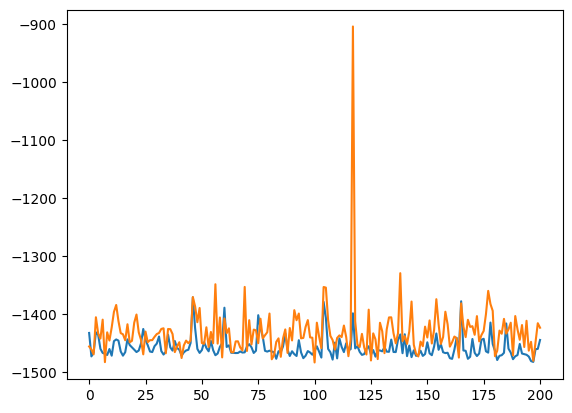

alpha 0.1 default_lr 0.0005


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [41]:
print(datetime.datetime.now())

2023-07-22 20:28:12.344039


# Iter 5

In [42]:
policy_evaluation_iter=4

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [ -0.86000776   9.88050513  -8.1173834  -29.59851822] [ 5.20277001e-03  9.65590854e+00 -5.03375890e-01 -9.85640880e+00] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 80

 13

 14

 15

 16
predict diverge [  0.42338536  11.38476386 -11.0641302  -10.99172637] [ 0.15086153  4.63117896 -0.4217928   7.64737722] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 90

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27
predict diverge [  6.56137831   6.56819381 -16.04707788 -22.01323841] [ 0.16875752  0.2344093  -0.3380356  -8.50656634] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 135

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46
predict diverge [ -0.89081001   2.1694087  -10.92205723 -44.03481991] [  0.04314728   

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.72256  validloss 0.88189±0.00000  bestvalidloss 0.88189  last_update 0
train: iter 1  trainloss 0.64508  validloss 0.68123±0.00000  bestvalidloss 0.68123  last_update 0
train: iter 2  trainloss 0.61888  validloss 0.67558±0.00000  bestvalidloss 0.67558  last_update 0
train: iter 3  trainloss 0.59961  validloss 0.65497±0.00000  bestvalidloss 0.65497  last_update 0
train: iter 4  trainloss 0.59763  validloss 0.69238±0.00000  bestvalidloss 0.65497  last_update 1
train: iter 5  trainloss 0.58827  validloss 0.64666±0.00000  bestvalidloss 0.64666  last_update 0
train: iter 6  trainloss 0.59163  validloss 0.65335±0.00000  bestvalidloss 0.64666  last_update 1
train: iter 7  trainloss 0.58219  validloss 0.64535±0.00000  bestvalidloss 0.64535  last_update 0
train: iter 8  trainloss 0.57721  validloss 0.64329±0.00000  bestvalidloss 0.64329  last_update 0
train: iter 9  trainloss 0.57764  validloss 0.62683±0.00000  bestvalidloss 0.62683  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.52830  validloss 0.60714±0.00000  bestvalidloss 0.59320  last_update 15
train: iter 84  trainloss 0.52844  validloss 0.62504±0.00000  bestvalidloss 0.59320  last_update 16
train: iter 85  trainloss 0.53216  validloss 0.62514±0.00000  bestvalidloss 0.59320  last_update 17
train: iter 86  trainloss 0.52727  validloss 0.60723±0.00000  bestvalidloss 0.59320  last_update 18
train: iter 87  trainloss 0.53140  validloss 0.61243±0.00000  bestvalidloss 0.59320  last_update 19
train: iter 88  trainloss 0.52679  validloss 0.61768±0.00000  bestvalidloss 0.59320  last_update 20
train: iter 89  trainloss 0.52797  validloss 0.61321±0.00000  bestvalidloss 0.59320  last_update 21
train: iter 90  trainloss 0.52878  validloss 0.62357±0.00000  bestvalidloss 0.59320  last_update 22
train: iter 91  trainloss 0.52842  validloss 0.60087±0.00000  bestvalidloss 0.59320  last_update 23
train: iter 92  trainloss 0.52952  validloss 0.60431±0.00000  bestvalidloss 0.59320  last_update 24


train: iter 165  trainloss 0.50617  validloss 0.60402±0.00000  bestvalidloss 0.58619  last_update 14
train: iter 166  trainloss 0.51210  validloss 0.59222±0.00000  bestvalidloss 0.58619  last_update 15
train: iter 167  trainloss 0.51333  validloss 0.59528±0.00000  bestvalidloss 0.58619  last_update 16
train: iter 168  trainloss 0.51138  validloss 0.61978±0.00000  bestvalidloss 0.58619  last_update 17
train: iter 169  trainloss 0.50632  validloss 0.61602±0.00000  bestvalidloss 0.58619  last_update 18
train: iter 170  trainloss 0.50748  validloss 0.58527±0.00000  bestvalidloss 0.58527  last_update 0
train: iter 171  trainloss 0.51142  validloss 0.61032±0.00000  bestvalidloss 0.58527  last_update 1
train: iter 172  trainloss 0.50713  validloss 0.60611±0.00000  bestvalidloss 0.58527  last_update 2
train: iter 173  trainloss 0.51072  validloss 0.58357±0.00000  bestvalidloss 0.58357  last_update 0
train: iter 174  trainloss 0.50836  validloss 0.60908±0.00000  bestvalidloss 0.58357  last_upda

train: iter 247  trainloss 0.49255  validloss 0.59991±0.00000  bestvalidloss 0.57262  last_update 35
train: iter 248  trainloss 0.48954  validloss 0.61396±0.00000  bestvalidloss 0.57262  last_update 36
train: iter 249  trainloss 0.49171  validloss 0.59610±0.00000  bestvalidloss 0.57262  last_update 37
train: iter 250  trainloss 0.49421  validloss 0.60522±0.00000  bestvalidloss 0.57262  last_update 38
train: iter 251  trainloss 0.49736  validloss 0.60143±0.00000  bestvalidloss 0.57262  last_update 39
train: iter 252  trainloss 0.48909  validloss 0.61784±0.00000  bestvalidloss 0.57262  last_update 40
train: iter 253  trainloss 0.49304  validloss 0.63654±0.00000  bestvalidloss 0.57262  last_update 41
train: iter 254  trainloss 0.49447  validloss 0.59883±0.00000  bestvalidloss 0.57262  last_update 42
train: iter 255  trainloss 0.49207  validloss 0.61633±0.00000  bestvalidloss 0.57262  last_update 43
train: iter 256  trainloss 0.49672  validloss 0.66044±0.00000  bestvalidloss 0.57262  last_

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.431747170946002
valid_loss:  -9.858017867946625
weight_alpha 1.0 h_min_tilde -12.310524 ell_tilde -7.9170013103461265 kappa_tilde 0.0004770825851210181
train_loss:  -6.713333947181701
valid_loss:  -6.630755047607421
weight_alpha 0.1 h_min_tilde -12.310524 ell_tilde -6.696818167266844 kappa_tilde 0.00042206095271067373


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1386.32398  validloss -1326.29790±0.00000  bestvalidloss -1326.29790  last_update 0
train: iter 1  trainloss -1389.28725  validloss -1363.41064±0.00000  bestvalidloss -1363.41064  last_update 0
train: iter 2  trainloss -1389.48759  validloss -1348.85005±0.00000  bestvalidloss -1363.41064  last_update 1
train: iter 3  trainloss -1400.20073  validloss -1339.53635±0.00000  bestvalidloss -1363.41064  last_update 2
train: iter 4  trainloss -1376.34611  validloss -1343.03904±0.00000  bestvalidloss -1363.41064  last_update 3
train: iter 5  trainloss -1393.64134  validloss -1339.24976±0.00000  bestvalidloss -1363.41064  last_update 4
train: iter 6  trainloss -1385.19491  validloss -1331.92284±0.00000  bestvalidloss -1363.41064  last_update 5
train: iter 7  trainloss -1402.47349  validloss -1364.61147±0.00000  bestvalidloss -1364.61147  last_update 0
train: iter 8  trainloss -1412.92410  validloss -1358.15441±0.00000  bestva

train: iter 74  trainloss -1394.63302  validloss -1356.84577±0.00000  bestvalidloss -1392.06670  last_update 36
train: iter 75  trainloss -1403.79924  validloss -1312.31274±0.00000  bestvalidloss -1392.06670  last_update 37
train: iter 76  trainloss -1390.67289  validloss -1337.17124±0.00000  bestvalidloss -1392.06670  last_update 38
train: iter 77  trainloss -1401.37113  validloss -1303.38670±0.00000  bestvalidloss -1392.06670  last_update 39
train: iter 78  trainloss -1411.18160  validloss -1381.13436±0.00000  bestvalidloss -1392.06670  last_update 40
train: iter 79  trainloss -1397.53959  validloss -1393.29804±0.00000  bestvalidloss -1393.29804  last_update 0
train: iter 80  trainloss -1372.47400  validloss -1371.63268±0.00000  bestvalidloss -1393.29804  last_update 1
train: iter 81  trainloss -1375.97121  validloss -1259.83097±0.00000  bestvalidloss -1393.29804  last_update 2
train: iter 82  trainloss -1389.11053  validloss -1338.33614±0.00000  bestvalidloss -1393.29804  last_updat

train: iter 147  trainloss -1412.80024  validloss -1326.04010±0.00000  bestvalidloss -1405.06775  last_update 50
train: iter 148  trainloss -1404.68704  validloss -1366.15196±0.00000  bestvalidloss -1405.06775  last_update 51
train: iter 149  trainloss -1415.85029  validloss -1306.56496±0.00000  bestvalidloss -1405.06775  last_update 52
train: iter 150  trainloss -1378.39482  validloss -1252.65586±0.00000  bestvalidloss -1405.06775  last_update 53
train: iter 151  trainloss -1401.96955  validloss -1364.77861±0.00000  bestvalidloss -1405.06775  last_update 54
train: iter 152  trainloss -1412.26759  validloss -1344.34573±0.00000  bestvalidloss -1405.06775  last_update 55
train: iter 153  trainloss -1404.32717  validloss -1308.93994±0.00000  bestvalidloss -1405.06775  last_update 56
train: iter 154  trainloss -1416.55346  validloss -1313.13068±0.00000  bestvalidloss -1405.06775  last_update 57
train: iter 155  trainloss -1418.57271  validloss -1324.52410±0.00000  bestvalidloss -1405.06775

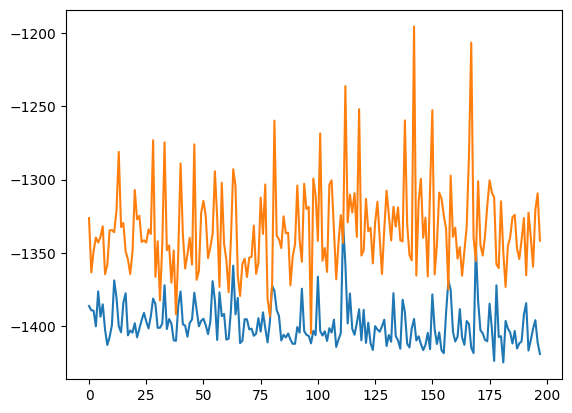

alpha 0.1 default_lr 0.0005


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [48]:
print(datetime.datetime.now())

2023-07-22 20:49:11.363583


# 評価関数計算

In [49]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79
predict diverge [ -1.31189192  -3.51196445  -7.37273568 -22.55476965] [-0.06485797 -1.708211   -0.41267296 -3.97326708] [26.959822  9.978687 55.22207  20.953142] [13.479911   4.9893436 27.611034  10.476571 ] sim_timestep 124

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [50]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.60142  validloss 0.63831±0.00000  bestvalidloss 0.63831  last_update 0
train: iter 1  trainloss 0.57731  validloss 0.56596±0.00000  bestvalidloss 0.56596  last_update 0
train: iter 2  trainloss 0.57303  validloss 0.58971±0.00000  bestvalidloss 0.56596  last_update 1
train: iter 3  trainloss 0.56093  validloss 0.55712±0.00000  bestvalidloss 0.55712  last_update 0
train: iter 4  trainloss 0.55367  validloss 0.55932±0.00000  bestvalidloss 0.55712  last_update 1
train: iter 5  trainloss 0.55337  validloss 0.55363±0.00000  bestvalidloss 0.55363  last_update 0
train: iter 6  trainloss 0.55430  validloss 0.54369±0.00000  bestvalidloss 0.54369  last_update 0
train: iter 7  trainloss 0.55437  validloss 0.55135±0.00000  bestvalidloss 0.54369  last_update 1
train: iter 8  trainloss 0.54530  validloss 0.54795±0.00000  bestvalidloss 0.54369  last_update 2
train: iter 9  trainloss 0.54331  validloss 0.55986±0.00000  bestvalidloss 0.54369  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.50070  validloss 0.54483±0.00000  bestvalidloss 0.53059  last_update 1
train: iter 84  trainloss 0.50465  validloss 0.54707±0.00000  bestvalidloss 0.53059  last_update 2
train: iter 85  trainloss 0.49852  validloss 0.54234±0.00000  bestvalidloss 0.53059  last_update 3
train: iter 86  trainloss 0.49957  validloss 0.55111±0.00000  bestvalidloss 0.53059  last_update 4
train: iter 87  trainloss 0.49609  validloss 0.54841±0.00000  bestvalidloss 0.53059  last_update 5
train: iter 88  trainloss 0.50397  validloss 0.56910±0.00000  bestvalidloss 0.53059  last_update 6
train: iter 89  trainloss 0.50055  validloss 0.56646±0.00000  bestvalidloss 0.53059  last_update 7
train: iter 90  trainloss 0.49801  validloss 0.57728±0.00000  bestvalidloss 0.53059  last_update 8
train: iter 91  trainloss 0.50162  validloss 0.57907±0.00000  bestvalidloss 0.53059  last_update 9
train: iter 92  trainloss 0.49661  validloss 0.54361±0.00000  bestvalidloss 0.53059  last_update 10
train: it

train: iter 165  trainloss 0.48359  validloss 0.55483±0.00000  bestvalidloss 0.52648  last_update 3
train: iter 166  trainloss 0.48843  validloss 0.53174±0.00000  bestvalidloss 0.52648  last_update 4
train: iter 167  trainloss 0.48298  validloss 0.54064±0.00000  bestvalidloss 0.52648  last_update 5
train: iter 168  trainloss 0.48659  validloss 0.56686±0.00000  bestvalidloss 0.52648  last_update 6
train: iter 169  trainloss 0.48111  validloss 0.53804±0.00000  bestvalidloss 0.52648  last_update 7
train: iter 170  trainloss 0.47960  validloss 0.55526±0.00000  bestvalidloss 0.52648  last_update 8
train: iter 171  trainloss 0.48325  validloss 0.55559±0.00000  bestvalidloss 0.52648  last_update 9
train: iter 172  trainloss 0.47849  validloss 0.53886±0.00000  bestvalidloss 0.52648  last_update 10
train: iter 173  trainloss 0.48919  validloss 0.54817±0.00000  bestvalidloss 0.52648  last_update 11
train: iter 174  trainloss 0.48123  validloss 0.57016±0.00000  bestvalidloss 0.52648  last_update 

train: iter 247  trainloss 0.47442  validloss 0.53322±0.00000  bestvalidloss 0.51471  last_update 6
train: iter 248  trainloss 0.46970  validloss 0.54165±0.00000  bestvalidloss 0.51471  last_update 7
train: iter 249  trainloss 0.47117  validloss 0.53233±0.00000  bestvalidloss 0.51471  last_update 8
train: iter 250  trainloss 0.47072  validloss 0.54873±0.00000  bestvalidloss 0.51471  last_update 9
train: iter 251  trainloss 0.47130  validloss 0.54690±0.00000  bestvalidloss 0.51471  last_update 10
train: iter 252  trainloss 0.47027  validloss 0.53854±0.00000  bestvalidloss 0.51471  last_update 11
train: iter 253  trainloss 0.46993  validloss 0.54558±0.00000  bestvalidloss 0.51471  last_update 12
train: iter 254  trainloss 0.46461  validloss 0.53475±0.00000  bestvalidloss 0.51471  last_update 13
train: iter 255  trainloss 0.46991  validloss 0.56948±0.00000  bestvalidloss 0.51471  last_update 14
train: iter 256  trainloss 0.47456  validloss 0.54516±0.00000  bestvalidloss 0.51471  last_upda

train: iter 329  trainloss 0.45833  validloss 0.54050±0.00000  bestvalidloss 0.51471  last_update 88
train: iter 330  trainloss 0.46205  validloss 0.53873±0.00000  bestvalidloss 0.51471  last_update 89
train: iter 331  trainloss 0.46103  validloss 0.54252±0.00000  bestvalidloss 0.51471  last_update 90
train: iter 332  trainloss 0.46276  validloss 0.54307±0.00000  bestvalidloss 0.51471  last_update 91
train: iter 333  trainloss 0.46326  validloss 0.55384±0.00000  bestvalidloss 0.51471  last_update 92
train: iter 334  trainloss 0.46613  validloss 0.53403±0.00000  bestvalidloss 0.51471  last_update 93
train: iter 335  trainloss 0.46080  validloss 0.54727±0.00000  bestvalidloss 0.51471  last_update 94
train: iter 336  trainloss 0.45691  validloss 0.54598±0.00000  bestvalidloss 0.51471  last_update 95
train: iter 337  trainloss 0.45750  validloss 0.54183±0.00000  bestvalidloss 0.51471  last_update 96
train: iter 338  trainloss 0.46052  validloss 0.55084±0.00000  bestvalidloss 0.51471  last_

([0.6014160724356771,
  0.5773135986179113,
  0.5730340503156185,
  0.560934168100357,
  0.5536651438102126,
  0.5533742504194379,
  0.5542990000918507,
  0.5543718509376049,
  0.5452980887144804,
  0.5433121178299188,
  0.543055261299014,
  0.5440126597881317,
  0.5407817326486111,
  0.538298350200057,
  0.5361196398735046,
  0.5359390975907445,
  0.5387818042188883,
  0.5343935480341315,
  0.531776700913906,
  0.5282619790174067,
  0.527362272143364,
  0.5286793373525143,
  0.527099396288395,
  0.528999381326139,
  0.5233226604759693,
  0.5265206095762551,
  0.5222619781270623,
  0.5203722999431193,
  0.5191426483914257,
  0.51997385378927,
  0.5210693177767098,
  0.5224120179191232,
  0.5188760872930288,
  0.5223290275782346,
  0.5216897441074252,
  0.5246376417577266,
  0.5181201200932264,
  0.5206433307379484,
  0.5167086486704647,
  0.5139767376706004,
  0.5208076357841491,
  0.5199900691397488,
  0.5156019216403365,
  0.5106826737523079,
  0.5146756091155111,
  0.514715419337153

In [51]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.454478768530487
valid_loss:  -6.21003069691658
weight_alpha 1.0 h_min_tilde -12.32384 ell_tilde -5.605589154207705 kappa_tilde 0.0003858085853300246
train_loss:  -6.500838288497922
valid_loss:  -6.113688526153565
weight_alpha 0.1 h_min_tilde -12.32384 ell_tilde -6.423408336029052 kappa_tilde 0.0004116784202490302


In [52]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 18.99200  validloss 16.25955±0.00000  bestvalidloss 16.25955  last_update 0
train: iter 1  trainloss 15.86977  validloss 13.02339±0.00000  bestvalidloss 13.02339  last_update 0
train: iter 2  trainloss 13.25623  validloss 10.39999±0.00000  bestvalidloss 10.39999  last_update 0
train: iter 3  trainloss 11.32651  validloss 8.65802±0.00000  bestvalidloss 8.65802  last_update 0
train: iter 4  trainloss 9.64604  validloss 6.94723±0.00000  bestvalidloss 6.94723  last_update 0
train: iter 5  trainloss 8.37138  validloss 5.62861±0.00000  bestvalidloss 5.62861  last_update 0
train: iter 6  trainloss 7.23172  validloss 4.69791±0.00000  bestvalidloss 4.69791  last_update 0
train: iter 7  trainloss 6.36511  validloss 3.89409±0.00000  bestvalidloss 3.89409  last_update 0
train: iter 8  trainloss 5.58392  validloss 3.15031±0.00000  bestvalidloss 3.15031  last_update 0
train: iter 9  trainloss 4.89232  validloss 2.58583±0.00000  bestvalidloss 2.58583  last_update 0
train: ite

train: iter 83  trainloss 0.98299  validloss 0.31889±0.00000  bestvalidloss 0.06326  last_update 57
train: iter 84  trainloss 0.99733  validloss 0.30391±0.00000  bestvalidloss 0.06326  last_update 58
train: iter 85  trainloss 0.97151  validloss 0.32147±0.00000  bestvalidloss 0.06326  last_update 59
train: iter 86  trainloss 0.96699  validloss 0.32920±0.00000  bestvalidloss 0.06326  last_update 60
train: iter 87  trainloss 0.98169  validloss 0.31410±0.00000  bestvalidloss 0.06326  last_update 61
train: iter 88  trainloss 0.97663  validloss 0.31765±0.00000  bestvalidloss 0.06326  last_update 62
train: iter 89  trainloss 0.97945  validloss 0.33245±0.00000  bestvalidloss 0.06326  last_update 63
train: iter 90  trainloss 0.97770  validloss 0.31296±0.00000  bestvalidloss 0.06326  last_update 64
train: iter 91  trainloss 0.98174  validloss 0.34680±0.00000  bestvalidloss 0.06326  last_update 65
train: iter 92  trainloss 0.97402  validloss 0.36274±0.00000  bestvalidloss 0.06326  last_update 66


In [53]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.5167, -1.6016, -2.6448, -2.8041], requires_grad=True)


In [54]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 2.84354  validloss 10.68028±0.00000  bestvalidloss 10.68028  last_update 0
train: iter 1  trainloss 2.15045  validloss 9.41989±0.00000  bestvalidloss 9.41989  last_update 0
train: iter 2  trainloss 2.10891  validloss 9.29801±0.00000  bestvalidloss 9.29801  last_update 0
train: iter 3  trainloss 2.09256  validloss 9.20932±0.00000  bestvalidloss 9.20932  last_update 0
train: iter 4  trainloss 2.09109  validloss 9.84761±0.00000  bestvalidloss 9.20932  last_update 1
train: iter 5  trainloss 2.07300  validloss 9.60423±0.00000  bestvalidloss 9.20932  last_update 2
train: iter 6  trainloss 2.05833  validloss 9.66625±0.00000  bestvalidloss 9.20932  last_update 3
train: iter 7  trainloss 2.05184  validloss 9.37962±0.00000  bestvalidloss 9.20932  last_update 4
train: iter 8  trainloss 2.09316  validloss 9.51186±0.00000  bestvalidloss 9.20932  last_update 5
train: iter 9  trainloss 2.08210  validloss 8.89867±0.00000  bestvalidloss 8.89867  last_update 0
train: iter 10  tr

train: iter 85  trainloss 2.03363  validloss 9.13312±0.00000  bestvalidloss 8.48548  last_update 13
train: iter 86  trainloss 2.02705  validloss 9.16678±0.00000  bestvalidloss 8.48548  last_update 14
train: iter 87  trainloss 2.08336  validloss 9.39192±0.00000  bestvalidloss 8.48548  last_update 15
train: iter 88  trainloss 2.04326  validloss 9.09336±0.00000  bestvalidloss 8.48548  last_update 16
train: iter 89  trainloss 2.02434  validloss 9.26836±0.00000  bestvalidloss 8.48548  last_update 17
train: iter 90  trainloss 2.00351  validloss 10.35509±0.00000  bestvalidloss 8.48548  last_update 18
train: iter 91  trainloss 2.01878  validloss 9.37787±0.00000  bestvalidloss 8.48548  last_update 19
train: iter 92  trainloss 1.97281  validloss 9.05138±0.00000  bestvalidloss 8.48548  last_update 20
train: iter 93  trainloss 2.05701  validloss 8.83179±0.00000  bestvalidloss 8.48548  last_update 21
train: iter 94  trainloss 2.01195  validloss 9.29268±0.00000  bestvalidloss 8.48548  last_update 22

train: iter 168  trainloss 1.99276  validloss 8.66802±0.00000  bestvalidloss 8.21938  last_update 39
train: iter 169  trainloss 2.05126  validloss 8.92620±0.00000  bestvalidloss 8.21938  last_update 40
train: iter 170  trainloss 2.05207  validloss 9.05549±0.00000  bestvalidloss 8.21938  last_update 41
train: iter 171  trainloss 2.01208  validloss 9.16248±0.00000  bestvalidloss 8.21938  last_update 42
train: iter 172  trainloss 2.03234  validloss 8.98767±0.00000  bestvalidloss 8.21938  last_update 43
train: iter 173  trainloss 2.01979  validloss 9.59730±0.00000  bestvalidloss 8.21938  last_update 44
train: iter 174  trainloss 2.03379  validloss 9.15603±0.00000  bestvalidloss 8.21938  last_update 45
train: iter 175  trainloss 2.05529  validloss 9.07570±0.00000  bestvalidloss 8.21938  last_update 46
train: iter 176  trainloss 2.00912  validloss 8.86064±0.00000  bestvalidloss 8.21938  last_update 47
train: iter 177  trainloss 1.99638  validloss 8.99292±0.00000  bestvalidloss 8.21938  last_

In [55]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.5672)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(8.3296)


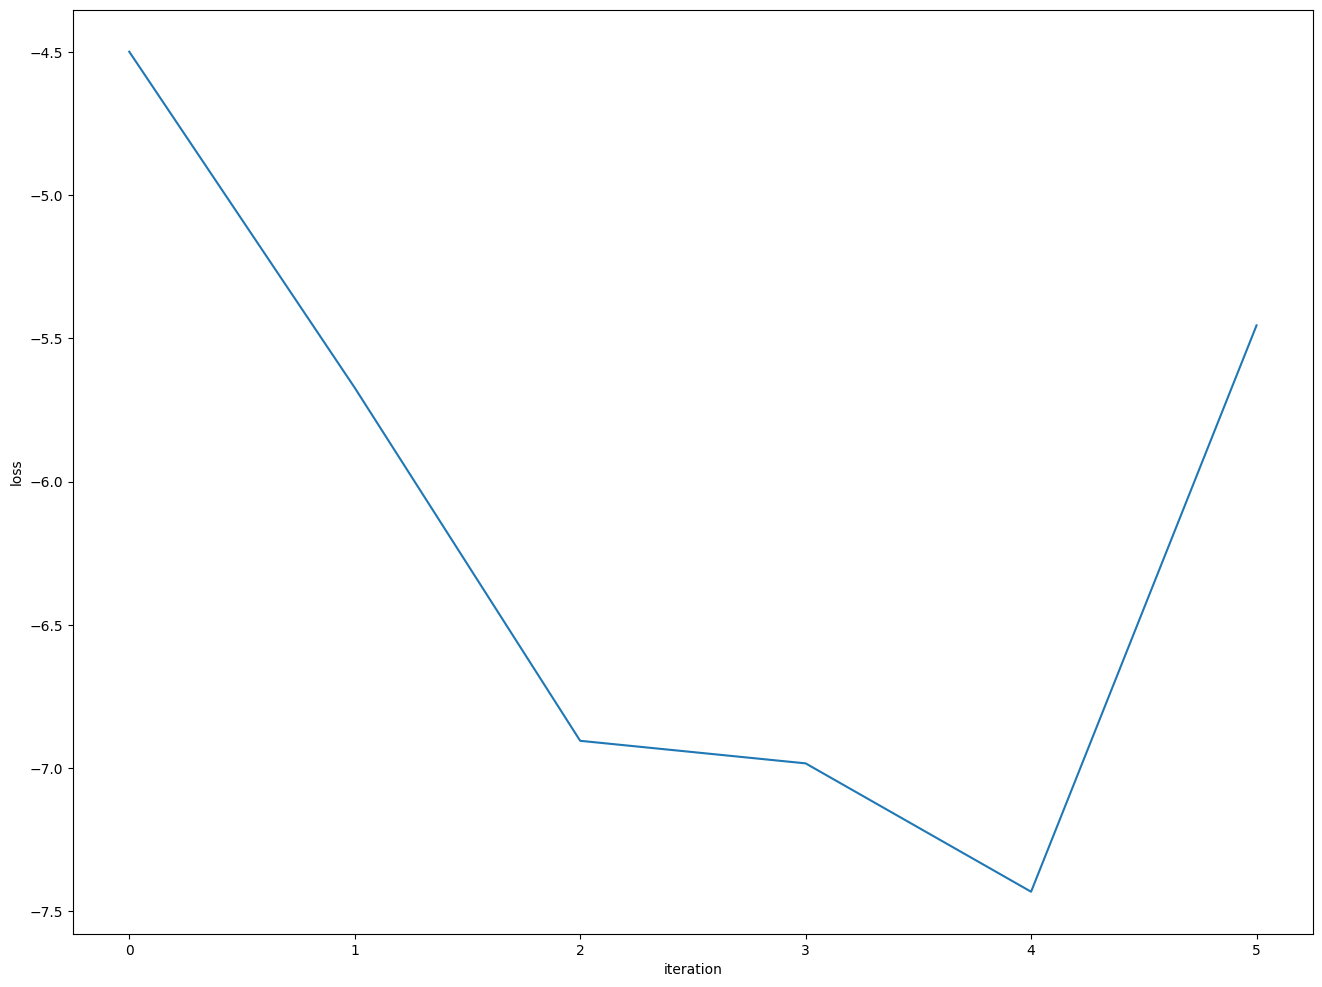

In [56]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

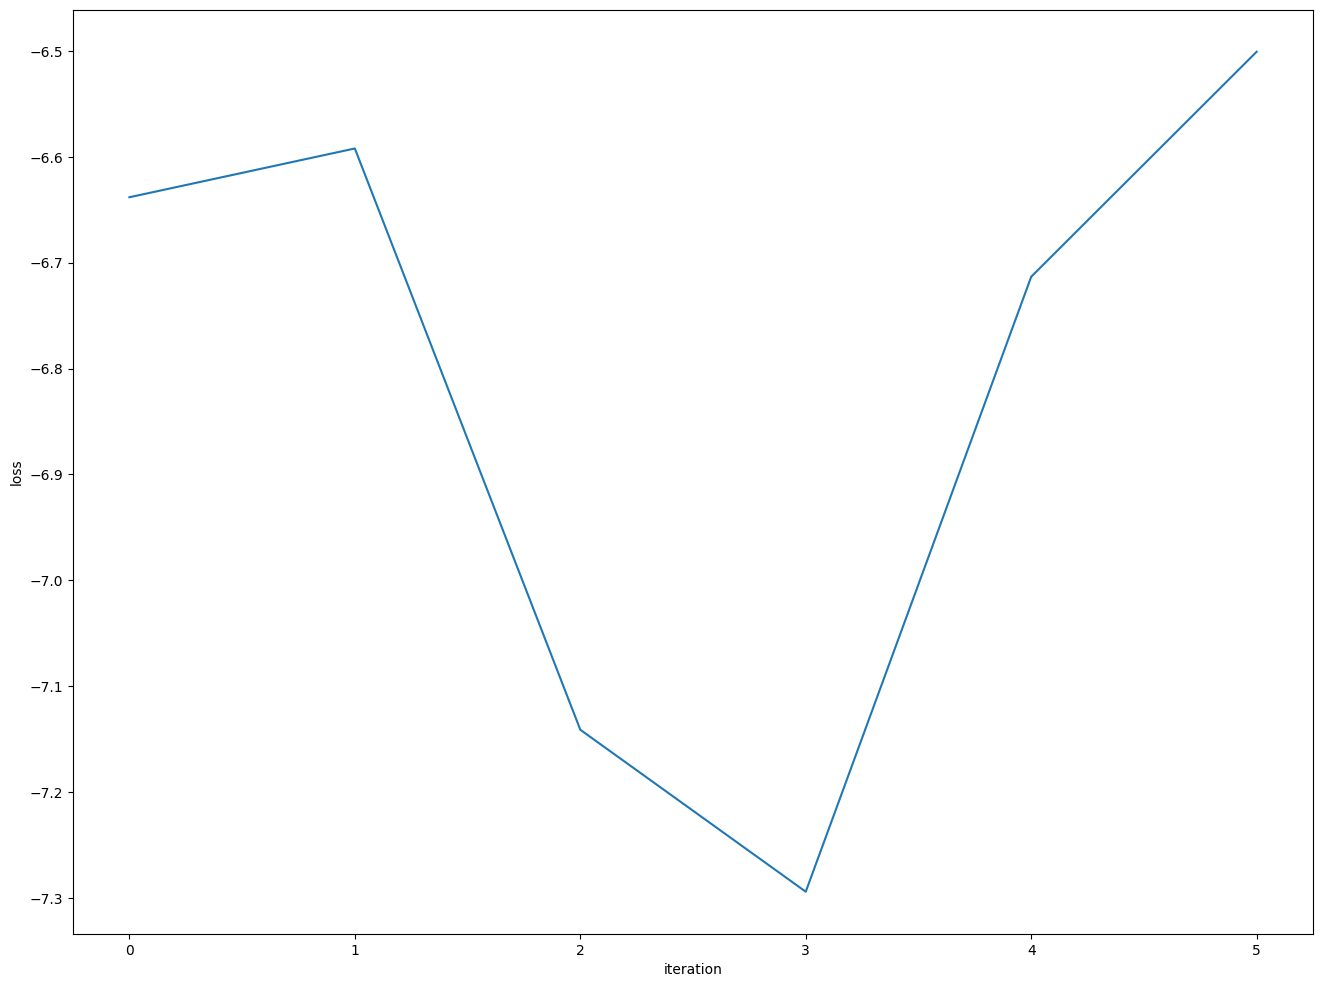

In [57]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")